# Analysis for NFL Teams Current Success Based on Essential Positions Historical Statistics

## Josh McCoy and Zach Goodman

[Link to website](https://joshmccoy2.github.io)

# Project Goals

The goal of our project is to analyze significant positions of NFL teams and see which statistics for those positions correlate to success. We will determine which positions in the NFL are important by utilizing salary cap data for each NFL team between 2014-2020. After we have idenitifed the most significant positions for NFL teams, we will create a predictive model that examines the statistics for that given position and will predict the total wins an NFL franchise should have in that given season.


### Importing all libraries and reading in all CSVs

In [237]:
import pandas as pd
import numpy as np
import math
import re 
import matplotlib.pyplot as plt
import matplotlib.pyplot
import requests
from bs4 import BeautifulSoup
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDRegressor
from sklearn import metrics
from sklearn.feature_extraction import DictVectorizer
from sklearn.preprocessing import StandardScaler



stadiums_df = pd.read_csv("stadiums.csv", encoding="ISO-8859-1") #import Stadium info
teams_df = pd.read_csv("nfl_teams.csv", encoding="ISO-8859-1")  #import Team info
scores_df = pd.read_csv("spreadspoke_scores.csv", encoding="ISO-8859-1") #import each game score/spread info
salary_cap = pd.read_csv("2014-thru-2020-cap-tables-1.csv", encoding="ISO-8859-1")
stats_tackles = pd.read_csv("2014-2020T.csv", encoding="ISO-8859-1",on_bad_lines='skip') #import stats for tackle position
stats_guards =  pd.read_csv("2014-2020G.csv", encoding="ISO-8859-1",on_bad_lines='skip')  #import stats for guard position

# ETL________________________________________________________

## NFL Teams and Scores Dataset

We obtained this data from the "NFL Scores and Betting Data" dataset found on Kaggle.com. It contains NFL game results since 1966, and information about the betting odds of each game since 1979, along with information about the weather from each game. The betting odds include the favored team, the over/under of each game and where the game was played. It also contains information about each stadium and team that has ever existed in the NFL.

#### Table 1:

This first table comes from "stadiums.csv", found in the "NFL Scores and Betting Data" dataset. It contains information about all of the stadiums that NFL games have been played in and ample information about each of them. For example, it has the stadium location, both in terms of city and coordinates, the opening and/or closing year of the arena, stadium type, weather type, capacity, and more. This dataframe can be useful in many different ways. Some questions we can answer by examining this dataframe is, which is the best stadium to play a football game in hot weather, or snowy weather? Does stadium capacity affect the outcome of games? Does the elevation, like in Denver, negatively affect the visiting team that isn't used to those conditions? 

In [238]:
stadiums_df.head(3)

,stadium_name,stadium_location,stadium_open,stadium_close,stadium_type,stadium_address,stadium_weather_station_code,stadium_weather_type,stadium_capacity,stadium_surface,STATION,NAME,LATITUDE,LONGITUDE,ELEVATION
0,Acrisure Stadium,"Pittsburgh, PA",2001.0,NaN,outdoor,"100 Art Rooney Ave, Pittsburgh, PA 15212",15212,cold,"65,500",Grass,USW00094823,"PITTSBURGH ASOS, PA US",40.4846,-80.2144,366.7
1,Alamo Dome,"San Antonio, TX",NaN,NaN,indoor,"100 Montana St, San Antonio, TX 78203",78203,dome,72000,FieldTurf,NaN,NaN,NaN,NaN,NaN
2,Allegiant Stadium,"Paradise, NV",2020.0,NaN,indoor,NaN,NaN,dome,65000,Grass,NaN,NaN,NaN,NaN,NaN


Lets check the dtypes.

In [239]:
stadiums_df.dtypes

stadium_name                     object
stadium_location                 object
stadium_open                    float64
stadium_close                   float64
stadium_type                     object
stadium_address                  object
stadium_weather_station_code     object
stadium_weather_type             object
stadium_capacity                 object
stadium_surface                  object
STATION                          object
NAME                             object
LATITUDE                        float64
LONGITUDE                       float64
ELEVATION                       float64
dtype: object

checking the dtypes we see that they are properly formatted.

##### Table 2:

This table comes from "nfl_teams.csv", also found in the "NFL Scores and Betting Data" dataset. It contains information about every team that is currently in the league, or has ever been in the NFL. As you can see, it contains the full and short team names, team IDs, and the teams' conference and division, both before and after 2002.

In [240]:
teams_df.head(3)

,team_name,team_name_short,team_id,team_id_pfr,team_conference,team_division,team_conference_pre2002,team_division_pre2002
0,Arizona Cardinals,Cardinals,ARI,CRD,NFC,NFC West,NFC,NFC West
1,Atlanta Falcons,Falcons,ATL,ATL,NFC,NFC South,NFC,NFC West
2,Baltimore Colts,Colts,IND,CLT,AFC,NaN,AFC,AFC East


#### Table 3:

This table comes from "spreadspoke_scores.csv", also found in NFL Scores and Betting Data" dataset. It contains information about the scores of each game since the inception of the NFL. Since we only care about modern football, we will limit it to 2014. This data will help us answer questions like "Which team has had the most success since 2014?" "Which teams have the best/worst record each year?". We will be combining this data with other datasets like salary cap information and position statistics to get a better understanding on what makes NFL teams successful.

In [241]:
scores_df.head(3)

,schedule_date,schedule_season,schedule_week,schedule_playoff,team_home,score_home,score_away,team_away,team_favorite_id,spread_favorite,over_under_line,stadium,stadium_neutral,weather_temperature,weather_wind_mph,weather_humidity,weather_detail
0,9/2/1966,1966,1,False,Miami Dolphins,14.0,23.0,Oakland Raiders,NaN,NaN,NaN,Orange Bowl,False,83.0,6.0,71.0,NaN
1,9/3/1966,1966,1,False,Houston Oilers,45.0,7.0,Denver Broncos,NaN,NaN,NaN,Rice Stadium,False,81.0,7.0,70.0,NaN
2,9/4/1966,1966,1,False,San Diego Chargers,27.0,7.0,Buffalo Bills,NaN,NaN,NaN,Balboa Stadium,False,70.0,7.0,82.0,NaN


Now, we are separating regular season games from playoff games. Our intended use of this data is to predict regular season wins. 

In [242]:
scores_df = scores_df[scores_df["schedule_season"]>=2014]  #limiting the dataFrame to dates 2014 and later
scores_df = scores_df[scores_df["schedule_playoff"]==False]
df_scores = pd.read_csv("spreadspoke_scores.csv", encoding="ISO-8859-1") #import each game score/spread info
playoffs = df_scores[df_scores["schedule_season"]>=2014]  #limiting the dataFrame to dates 2014 and later
playoffs = playoffs[playoffs["schedule_playoff"]==True]
scores_df.head(3)


,schedule_date,schedule_season,schedule_week,schedule_playoff,team_home,score_home,score_away,team_away,team_favorite_id,spread_favorite,over_under_line,stadium,stadium_neutral,weather_temperature,weather_wind_mph,weather_humidity,weather_detail
11076,9/4/2014,2014,1,False,Seattle Seahawks,36.0,16.0,Green Bay Packers,SEA,-4.5,46.5,CenturyLink Field,False,70.0,5.0,NaN,NaN
11077,9/7/2014,2014,1,False,Atlanta Falcons,37.0,34.0,New Orleans Saints,NO,-3.0,52,Georgia Dome,False,72.0,0.0,NaN,DOME
11078,9/7/2014,2014,1,False,Baltimore Ravens,16.0,23.0,Cincinnati Bengals,BAL,-1.0,42.5,M&T Bank Stadium,False,78.0,0.0,NaN,NaN


Now, we create a column to add in away and home wins, as well as away and home losses.

In [243]:
scores_df['away_win'] = np.where(scores_df['score_home'] < scores_df['score_away'], 1, 0)
scores_df['away_loss'] = np.where(scores_df['score_home'] > scores_df['score_away'], 1, 0)
scores_df['home_win'] = np.where(scores_df['score_home'] > scores_df['score_away'], 1, 0)
scores_df['home_loss'] = np.where(scores_df['score_home'] < scores_df['score_away'], 1, 0)
scores_df.head(3)

,schedule_date,schedule_season,schedule_week,schedule_playoff,team_home,score_home,score_away,team_away,team_favorite_id,spread_favorite,...,stadium,stadium_neutral,weather_temperature,weather_wind_mph,weather_humidity,weather_detail,away_win,away_loss,home_win,home_loss
11076,9/4/2014,2014,1,False,Seattle Seahawks,36.0,16.0,Green Bay Packers,SEA,-4.5,...,CenturyLink Field,False,70.0,5.0,NaN,NaN,0,1,1,0
11077,9/7/2014,2014,1,False,Atlanta Falcons,37.0,34.0,New Orleans Saints,NO,-3.0,...,Georgia Dome,False,72.0,0.0,NaN,DOME,0,1,1,0
11078,9/7/2014,2014,1,False,Baltimore Ravens,16.0,23.0,Cincinnati Bengals,BAL,-1.0,...,M&T Bank Stadium,False,78.0,0.0,NaN,NaN,1,0,0,1


Now, we want to sum all these wins and losses to create a table to see the total success of these teams.

In [244]:
record = pd.DataFrame()
record["home_win"] = scores_df.groupby("team_home")[["home_win"]].sum() 
record["home_loss"] = scores_df.groupby("team_home")[["home_loss"]].sum() 
record["away_win"] = scores_df.groupby("team_away")[["away_win"]].sum()
record["away_loss"] = scores_df.groupby("team_away")[["away_loss"]].sum()
record["total_win"] = record["home_win"] + record["away_win"] 
record["total_loss"] = record["home_loss"] + record["away_loss"]
record = record.reset_index()
record = record.rename(columns={'team_home': 'team_name'})
record.head(3)

,team_name,home_win,home_loss,away_win,away_loss,total_win,total_loss
0,Arizona Cardinals,32,33,36,31,68,64
1,Atlanta Falcons,29,37,33,35,62,72
2,Baltimore Ravens,44,24,34,32,78,56


Finally, we will add this table (record) to our original team table (team_name).

In [245]:
teams_df = teams_df.merge(record, on=["team_name"], how='inner', suffixes=(False, False))
teams_df = teams_df.set_index("team_name")
teams_df.head(3)

,team_name_short,team_id,team_id_pfr,team_conference,team_division,team_conference_pre2002,team_division_pre2002,home_win,home_loss,away_win,away_loss,total_win,total_loss
team_name,,,,,,,,,,,,,
Arizona Cardinals,Cardinals,ARI,CRD,NFC,NFC West,NFC,NFC West,32,33,36,31,68,64
Atlanta Falcons,Falcons,ATL,ATL,NFC,NFC South,NFC,NFC West,29,37,33,35,62,72
Baltimore Ravens,Ravens,BAL,RAV,AFC,AFC North,AFC,AFC Central,44,24,34,32,78,56


Now, we will check the dtype. 

In [246]:
teams_df.dtypes

team_name_short            object
team_id                    object
team_id_pfr                object
team_conference            object
team_division              object
team_conference_pre2002    object
team_division_pre2002      object
home_win                    int64
home_loss                   int64
away_win                    int64
away_loss                   int64
total_win                   int64
total_loss                  int64
dtype: object

#### Table 4:

salary_cap was found in the NFL Salaries dataset on Kaggle.com and identifies the cap space information for each team like player name, position, cap hit, cap percentage, season, and team. Salary Cap limits NFL franchises in the amount of money they spend on their respective players. This is important because we want to analyze if there is a difference in the positions taking up the most cap percentage for unsuccessful teams versus successful teams.

In [247]:
salary_cap = salary_cap.sort_values(by=["team", "season", "pos"], ascending=True)
salary_cap = salary_cap.rename(columns={"name":"Player"})

In [248]:
salary_cap

,Player,pos,cap_hit,cap_percent,season,team
48,Lyle Sendlein,C,4125000,3.04,2014,Arizona Cardinals
35,Patrick Peterson,CB,6937132,5.11,2014,Arizona Cardinals
43,Jerraud Powers,CB,4750000,3.50,2014,Arizona Cardinals
50,Antonio Cromartie,CB,4000000,2.94,2014,Arizona Cardinals
230,Justin Bethel,CB,598556,0.44,2014,Arizona Cardinals
...,...,...,...,...,...,...
12029,Kelvin Harmon,WR,526960,0.27,2019,Washington Redskins
12041,Steven Sims Jr.,WR,500000,0.26,2019,Washington Redskins
12081,Cam Sims,WR,174705,0.09,2019,Washington Redskins
12087,Darvin Kidsy,WR,116472,0.06,2019,Washington Redskins


In [249]:
salary_cap[salary_cap["team"]=="Green Bay Packers "]
#Fixed an issue where "Green Bay Packers" was actually "Green Bay Packers "
salary_cap['team'] = salary_cap['team'].str.replace('Green Bay Packers ','Green Bay Packers')
salary_cap.head(3)

,Player,pos,cap_hit,cap_percent,season,team
48,Lyle Sendlein,C,4125000,3.04,2014,Arizona Cardinals
35,Patrick Peterson,CB,6937132,5.11,2014,Arizona Cardinals
43,Jerraud Powers,CB,4750000,3.50,2014,Arizona Cardinals


In [250]:
salary_cap.dtypes

Player          object
pos             object
cap_hit          int64
cap_percent    float64
season           int64
team            object
dtype: object

The dtypes for each are correct.

# EDA

#### Step 1

First, we want to display the total wins by each NFL franchise in each season. We also want to distinguish by an away win/loss and a home win/loss. In our analysis we want to see if there is a difference in the type of atmosphere that a player is in. For instance, some QBs perform better at home than on road games. This could be because their stadium at home is a dome, and they struggle to throw outside in the weather. Therefore, we are creating a dataframe that has this difference. We are looking at per season record to distinguish teams in each season to help us further analyze what makes good teams good. 

In [251]:
seasonRecord = pd.DataFrame()
seasonRecord["Season"] = scores_df["schedule_season"]
seasonRecord["Home Team"] = scores_df["team_home"]
seasonRecord["Away Team"] = scores_df["team_away"]
seasonRecord["home_win"] = scores_df["home_win"]
seasonRecord["away_win"] = scores_df["away_win"]
seasonRecord["away_loss"] = scores_df["away_loss"]
seasonRecord["home_loss"] = scores_df["home_loss"]

In [252]:
hometeam_wins = seasonRecord.groupby(["Home Team","Season"])[["home_win"]].sum() 
hometeam_loss = seasonRecord.groupby(["Home Team","Season"])[["home_loss"]].sum() 
awayteam_loss = seasonRecord.groupby(["Away Team","Season"])[["away_loss"]].sum() 
awayteam_wins = seasonRecord.groupby(["Away Team","Season"])[["away_win"]].sum()

In [253]:
groupby_names = [hometeam_wins, hometeam_loss, awayteam_wins, awayteam_loss]
piv_names = ["homeTeamWinsPivot", "homeTeamLossPivot", "awayTeamWinsPivot", "awayTeamLossPivot"]
dfs = ["homeWin", "homeLoss", "awayWin", "awayLoss"]
colNames = ["home_win", "home_loss", "away_win", "away_loss"]
indexNames = ["Home Team", "Home Team", "Away Team", "Away Team"]  

for i in range(len(groupby_names)):
    globals()[piv_names[i]] = pd.pivot_table(groupby_names[i], values=colNames[i], index=indexNames[i], columns="Season")
    globals()[dfs[i]] = globals()[piv_names[i]].reset_index()
    globals()[dfs[i]] = globals()[dfs[i]].rename(columns={indexNames[i]:"Team"})
    globals()[dfs[i]] = globals()[dfs[i]].set_index(["Team"])
    

In [254]:
#Creating a dataframe with just wins: seasonWins
seasonWins = pd.DataFrame()
#Creating a dataframe with just losses: seasonLosses
seasonLoss = pd.DataFrame()
season_yrs = [2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022]
for year in range(len(season_yrs)):
    stringW = str(season_yrs[year]) + " W"
    stringL = str(season_yrs[year]) + " L"
    seasonWins[stringW] = homeWin[season_yrs[year]] + awayWin[season_yrs[year]]
    seasonLoss[stringL] = homeLoss[season_yrs[year]] + awayLoss[season_yrs[year]]
    year += 1

In [255]:
#Creating a dataframe with both wins and losses
year_rec = pd.DataFrame()
year_rec = seasonWins.merge(seasonLoss, on=["Team"])
insert_num = 1
for year in range(len(season_yrs)):
    stringL = str(season_yrs[year]) + " L"
    column_to_move = year_rec.pop(stringL)
    year_rec.insert(insert_num, stringL, column_to_move)
    insert_num += 2
year_rec.head(3)

,2014 W,2014 L,2015 W,2015 L,2016 W,2016 L,2017 W,2017 L,2018 W,2018 L,2019 W,2019 L,2020 W,2020 L,2021 W,2021 L,2022 W,2022 L
Team,,,,,,,,,,,,,,,,,,
Arizona Cardinals,11.0,5.0,13.0,3.0,7.0,8.0,8.0,8.0,3.0,13.0,5.0,10.0,8.0,8.0,11.0,6.0,2.0,3.0
Atlanta Falcons,6.0,10.0,8.0,8.0,11.0,5.0,10.0,6.0,7.0,9.0,7.0,9.0,4.0,12.0,7.0,10.0,2.0,3.0
Baltimore Ravens,10.0,6.0,5.0,11.0,8.0,8.0,9.0,7.0,10.0,6.0,14.0,2.0,11.0,5.0,8.0,9.0,3.0,2.0


We want to graph each teams amount of wins for each season from 2014-2020. Because there are 32 teams and reading 32 lines on one graph is hard to follow, we will do this by breaking the teams apart based on their respective divisions: NFC East, NFC South, AFC East, etc. We will need this data and charts for later use to overlay other graphs on top of these charts to support our analysis from the positions we identify as significant. 

In [256]:
seasonWins_to2020 = pd.DataFrame(seasonWins)
seasonWins_to2020 = seasonWins_to2020.drop(columns=["2021 W", "2022 W"])
seasonWins_to2020 = seasonWins_to2020.drop(index="Washington Commanders")

In [257]:
year_rec = pd.DataFrame()
year_rec = seasonWins.merge(seasonLoss, on=["Team"])
insert_num = 1
for year in range(len(season_yrs)):
   stringL = str(season_yrs[year]) + " L"
   column_to_move = year_rec.pop(stringL)
   year_rec.insert(insert_num, stringL, column_to_move)
   insert_num += 2
year_rec.head(3)

,2014 W,2014 L,2015 W,2015 L,2016 W,2016 L,2017 W,2017 L,2018 W,2018 L,2019 W,2019 L,2020 W,2020 L,2021 W,2021 L,2022 W,2022 L
Team,,,,,,,,,,,,,,,,,,
Arizona Cardinals,11.0,5.0,13.0,3.0,7.0,8.0,8.0,8.0,3.0,13.0,5.0,10.0,8.0,8.0,11.0,6.0,2.0,3.0
Atlanta Falcons,6.0,10.0,8.0,8.0,11.0,5.0,10.0,6.0,7.0,9.0,7.0,9.0,4.0,12.0,7.0,10.0,2.0,3.0
Baltimore Ravens,10.0,6.0,5.0,11.0,8.0,8.0,9.0,7.0,10.0,6.0,14.0,2.0,11.0,5.0,8.0,9.0,3.0,2.0


In [258]:
num = 14
for i in range(20-13):
    x = "cap" + str(num) 
    globals()[x] = pd.DataFrame(salary_cap)
    fullYr = int(str(20) + str(num))
    globals()[x] = globals()[x][globals()[x]["season"]==fullYr]
    num += 1

In [259]:
yrNum = 14
caps = [cap14["team"], cap15["team"], cap16["team"], cap17["team"], cap18["team"], cap19["team"], cap20["team"]]
for i in range(20-13):
    bigTeam = "big_team_list" + str(yrNum)
    tmLst = "team_list" + str(yrNum)
    globals()[tmLst] = []
    
    globals()[bigTeam] = caps[i]
    globals()[bigTeam] = globals()[bigTeam].values.tolist()
    
    [globals()[tmLst].append(x) for x in globals()[bigTeam] if x not in globals()[tmLst]]
    yrNum += 1

In [260]:
massive_list = salary_cap["team"].values.tolist()
full_team_list = []
[full_team_list.append(x) for x in massive_list if x not in full_team_list]
[]

[]

In [261]:
idx_list = []
for i in range(1120):
    idx_list.append(i)    
top5 = pd.DataFrame(index=idx_list, columns=["Player", "pos", "cap_percent", "season", "team"])
top5["Season Wins"] = float('nan')

In [262]:
seasonWinGraph = pd.DataFrame(seasonWins_to2020)
seasonWinGraph = homeTeamWinsPivot + awayTeamWinsPivot
seasonWinGraph = seasonWinGraph.rename_axis(index={"Home Team": "Team"})
seasonWinGraph = seasonWinGraph.drop(columns=[2021, 2022])

current_teams = pd.DataFrame(teams_df, columns=["team_name", "team_division"])
current_teams = current_teams.drop(columns=["team_name"])
current_teams= current_teams.rename_axis(index={"team_name": "Team"})

current_teams = current_teams.merge(seasonWinGraph, on=["Team"], how='inner', suffixes=(False, False))
current_teams = current_teams.drop(columns=[2014, 2015, 2016, 2017, 2018, 2019, 2020])
current_teams.loc["St. Louis Rams"]["team_division"] == "NFC West"
current_teams.at["St. Louis Rams", "team_division"] = "NFC West"
current_teams.at["Las Vegas Raiders", "team_division"] = "AFC West"
current_teams = current_teams.drop(index="Washington Commanders")
seasonWinGraph = pd.DataFrame.transpose(seasonWinGraph)

In [263]:
season_years = [2014, 2015, 2016, 2017, 2018, 2019, 2020]
nfl_leagues = ["AFC", "NFC"]
divs = ["North", "South", "East", "West"]
league_divs = []
for i in range(len(nfl_leagues)):
    league = nfl_leagues[i]
    for x in range(len(divs)):
        div = divs[x]
        strng = league + " " + div
        league_divs.append(strng)
afc = []
afc = league_divs[0:4]
nfc = []
nfc = league_divs[4:]

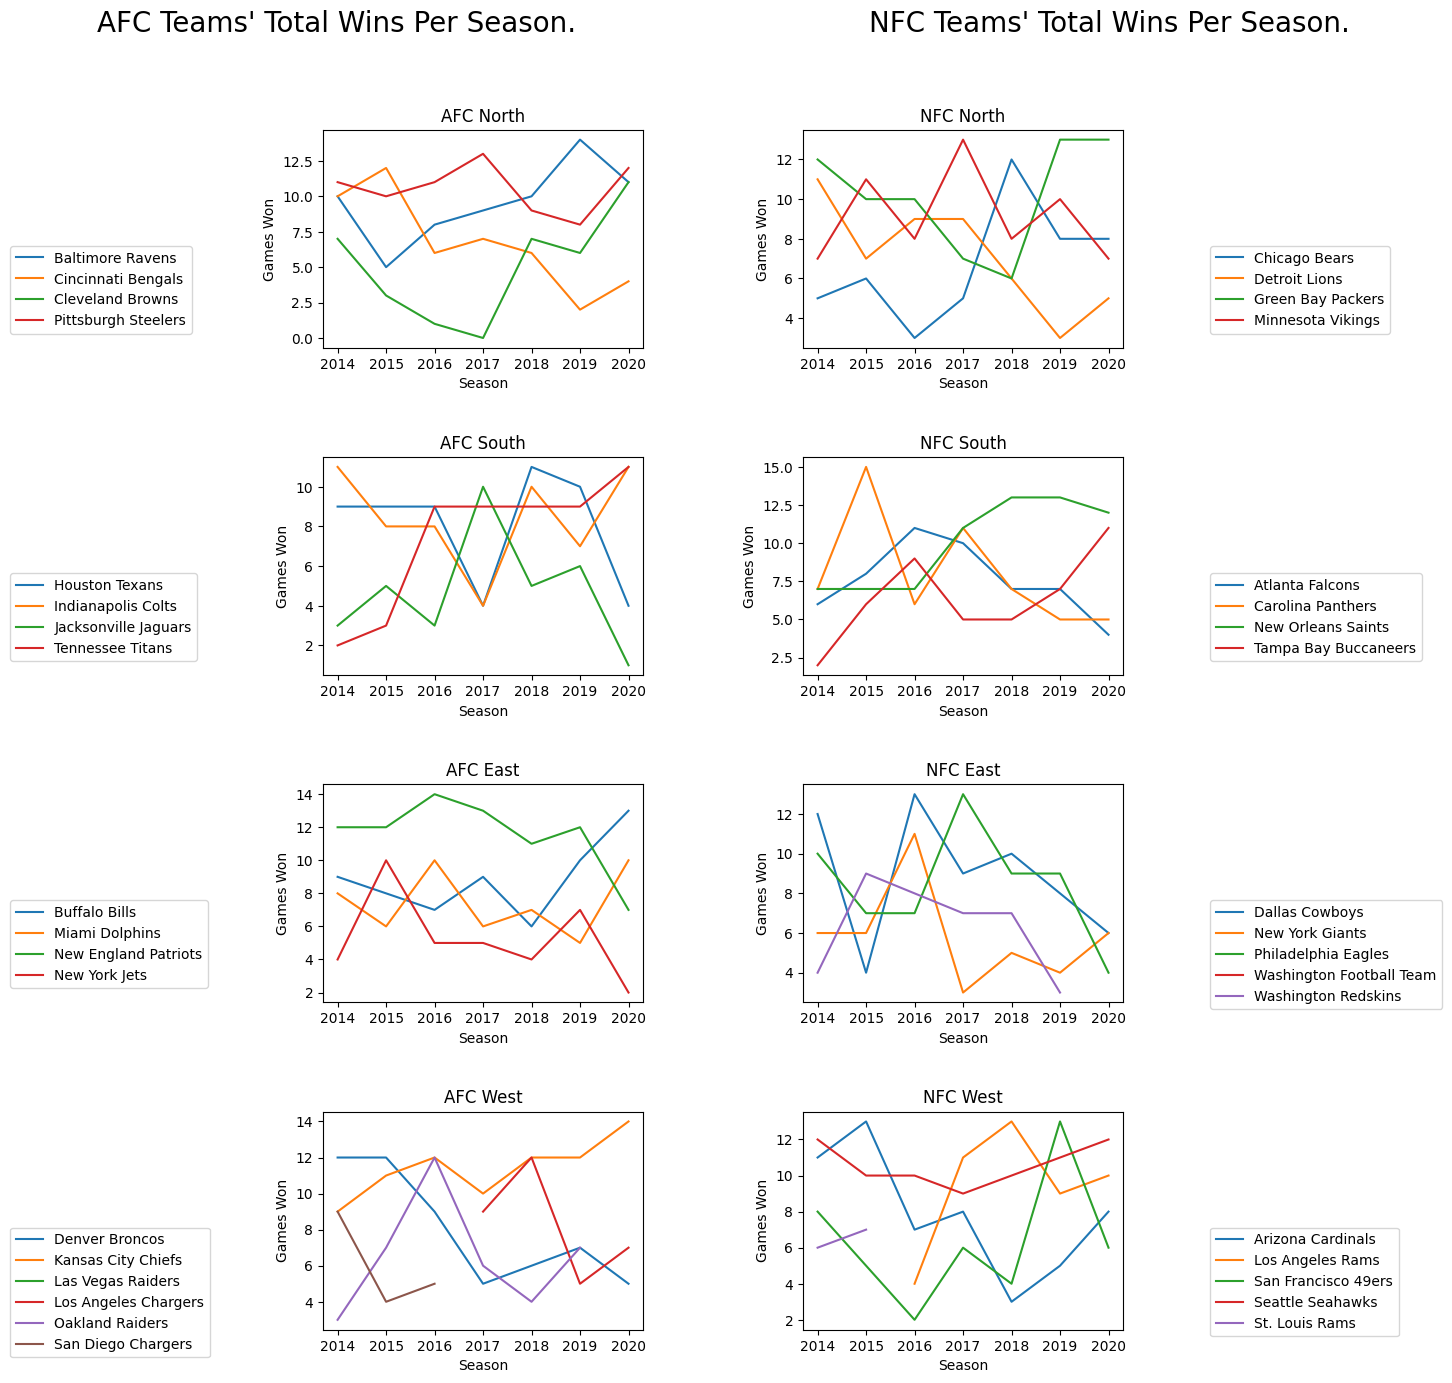

In [264]:
var = 0
fig, ax = plt.subplots(4, 2, figsize=(10,15), layout='constrained')    
fig.tight_layout(pad=5.0)
fig.subplots_adjust(left = 0.1, top = 0.9, right = 0.9, bottom = 0.1, hspace = 0.5, wspace = 0.5)
title = "AFC Teams' Total Wins Per Season.                                 NFC Teams' Total Wins Per Season." + "\n"
fig.suptitle(title, fontsize=20)
label_loc = 0

for var in range(2):
    xfc = afc
    label_loc = -1
    if (var==1):
        xfc = nfc
        label_loc = +1.25
        
    for team in range(len(full_team_list)):
    
        for league in range(len(xfc)):
            league = (league%4)
        
            if (current_teams.loc[full_team_list[team]]["team_division"] == xfc[league]) == True:
                                   
                ax[league][var].set_xlabel('Season')
                ax[league][var].set_ylabel('Games Won')

                ax[league][var].plot(season_years, seasonWinGraph[full_team_list[team]], label=full_team_list[team])
                ax[league][var].legend(loc='upper left', bbox_to_anchor=(label_loc, .5))
                
    for league in range(len(xfc)):
        
        ax[league][var].set_title(xfc[league])

    var += 1
    
plt.show(var)

This graphs will be extremely useful for the future. We plan to overlay different statistics that our model identifies as important from the position groups we have identified to show how they link to overall wins. 

#### Step 2

Now that we have each teams wins and losses for each season, we can define what it means to be a good, averaege, and bad team. We will do this by taking the STD, mean, and analyzing boxplots of wins per team for each season from 2014-2020. This is because our Salary Cap dataset only has data from 2014-2020.

In [265]:
seasonWins_to2020.std().mean()

3.1742396172056004

In [266]:
seasonWins_to2020.mean().mean()

7.96875

When looking at mean and STD it shows us that the average amount of wins per season is approximately 8. Let's generalize that 8 wins is the average and any team within one standard deviation is considered average. Therefore, 0-4 wins classify a team as "Bad", 5-11 wins classify a team as "Average", and 12-16 wins classify a team as "Good".

In [267]:
seasonWins_to2020.median().mean()

7.857142857142857

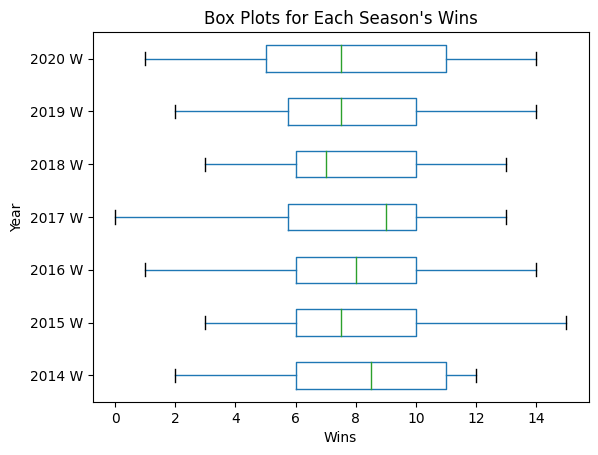

In [268]:
boxplot = seasonWins_to2020.boxplot(grid=False,vert=False)
plt.xlabel('Wins') 
plt.ylabel('Year') 
plt.title("Box Plots for Each Season's Wins")
plt.show(boxplot)

When looking at median and boxplots we see that the median (7.86) is almost exactly our mean (7.97) which indicates that the data is normally distributed. Therefore, we do not have to worry about too many outliars. This outcome further justifies our definitions for good, average, and bad. 

It is also worth mentioning that the 3rd quartile (75%) is right around 10 wins on average and the 1st quartile (25%) is right 5 wins on average. This further supports are definitions.

#### Step 3:

Now, we want to classify these teams into our stated definitions of "good", "average", and "bad". Once they are classified into these groups, we will then use the Salary Cap dataframe to identify what the top 5 positions for that team were in terms of salary cap percentage. Next, we will count the total number of positions by each group: good, average, and bad, to try to identify if there are differences in the positional valuation. 

First, for every NFL franchise, lets see how every position takes a bite out the pie:). In other words, what positions does the NFL at a whole value higher than others. This provides us with a basis going forward.

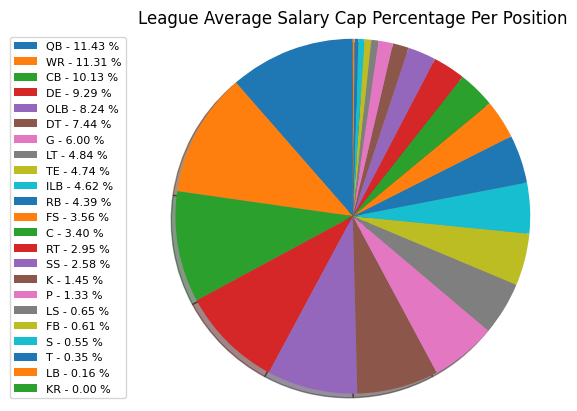

In [269]:
y = salary_cap.groupby("pos")[["cap_percent"]].sum()
y = y.reset_index()
y.groupby("pos")[["cap_percent"]].sum()
y.sort_values("cap_percent",ascending=False,inplace=True)

mylabels = y["pos"]
ys = y["cap_percent"]

porcent = 100.*ys/ys.sum()
patches, texts = plt.pie(ys, startangle=90, radius=1.2,shadow = True)
labels = ['{0} - {1:1.2f} %'.format(i,j) for i,j in zip(mylabels,porcent)]

sort_legend = True
if sort_legend:
    patches, labels, dummy =  zip(*sorted(zip(patches, labels, ys),
                                          key=lambda x: x[2],
                                          reverse=True))

plt.legend(patches, labels, loc='upper right', bbox_to_anchor=(-0.1, 1.),
           fontsize=8)
plt.title("League Average Salary Cap Percentage Per Position")

plt.show()

Throughout the years 2014-2020, there is a large portion of the teams cap_percentage going towards QB, WR, CB, DE, OLB, G, and DT. Right around 64% of any given teams total cap space is devoted to these 7 positions. We will further investigate this to see if winning franchises pay different positions more frequently than losing franchises.

In [270]:
number = 2014
Win_Values = [16.0, 15.0, 14.0, 13.0, 12.0, 11.0, 10.0, 9.0, 8.0, 7.0, 6.0, 5.0, 4.0, 3.0, 2.0, 1.0, 0.0]
pos_list = ["C", "CB", "DE", "DT", "FB", "FS", "G", "ILB", "K", "KR", "LB", "LS", "LT", "OLB", "P", "QB", "RB", "RT", "S", "SS", "T", "TE", "WR"] 


for i in range(20-13):
    var = "win" + str(number) 
    globals()[var] = pd.DataFrame()
    globals()[var]["Win Values"] = Win_Values
    globals()[var] = globals()[var].set_index("Win Values")
    
        
    for position in pos_list:
        globals()[var][position] = 0 
    
    number += 1

In [271]:
season_years = [2014, 2015, 2016, 2017, 2018, 2019, 2020]
season_yrs = [2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022]
pos_list = ["C", "CB", "DE", "DT", "FB", "FS", "G", "ILB", "K", "KR", "LB", "LS", "LT", "OLB", "P", "QB", "RB", "RT", "S", "SS", "T", "TE", "WR"] 
year = 2014
yr = 14
x=0
for year in range(len(season_years)):
    
    lst = "team_list" + str(yr)
    
    cap = "cap" + str(yr)
    
    stringW = str(season_yrs[year]) + " W"
    
    df_name = "win" + str(season_years[year])
    
    for team in globals()[lst]:
        winScore = year_rec[stringW].loc[team]
    
        df = globals()[cap][globals()[cap]["team"]==team].sort_values(by = ["cap_percent"], ascending=False).head(5)


        df = df.reset_index()
    
        for i in range(len(df)):
            top5.loc[x] = df.iloc[i]
            x = x + 1

        for position in pos_list:
            for i in range(len(df["pos"])):
                if df.loc[i]["pos"] == position:
                    globals()[df_name].loc[winScore][position] = globals()[df_name].loc[winScore][position] + 1
    
    year += 1
    yr += 1

In [272]:
for year in range(len(season_years)):
    transposed = "w" + str(season_years[year])
    og = "win" + str(season_years[year])   
    globals()[transposed] = pd.DataFrame.transpose(globals()[og])

In [273]:
#All the stats added up from seasons 2014-2020
w14to20 = pd.DataFrame()
w14to20 = w2014 + w2015 + w2016 + w2017 + w2018 + w2019 + w2020

In [274]:
good = pd.DataFrame()
average = pd.DataFrame()
bad = pd.DataFrame()

for i in range(5):
    score = i + 12.0
    iscore = i + 0.0
    bad[iscore] = w14to20[iscore]
    good[score] = w14to20[score]
    
for i in range(7):
    score = i + 5.0
    average[score] = w14to20[score]

In [275]:
pos_freq = pd.DataFrame(index=w14to20.index, columns=["Good", "Average", "Bad"])
# pos_freq(columns =["Good", "Average", "Bad"] = 0

levels = [good, average, bad]
level_str = ["Good", "Average", "Bad"]

for i in range(len(levels)):
    pos_freq[level_str[i]] = levels[i].sum(axis=1)

# pos_freq["Good"] = good.sum(axis=1)
# pos_freq["Average"] = average.sum(axis=1)
# pos_freq["Bad"] = bad.sum(axis=1)
#pos_freq.sort_values(by=["Good"], ascending=False)
#top 5 for Good: QB, LT, WR, OLB, CB
#pos_freq.sort_values(by=["Average"], ascending=False)
#top 5 for Average: QB, DE, WR, CB, OLB
#pos_freq.sort_values(by=["Bad"], ascending=False)

#top 5 for Good: QB, LT, WR, OLB, CB
#top 5 for Average: QB, DE, WR, CB, OLB
#top 5 for Bad: WR, CB, QB, DE, OLB
# pos_freq.sum(axis=1).sort_values(ascending=False)
#pos_freq.sum(axis=1).sort_values(ascending=False)

In [276]:
for year in range(len(season_years)):
    string = str(season_years[year]) + " W"
    
    for team in range(len(full_team_list)):
        
        for i in range(len(top5)):
            
            if (top5.loc[i]["season"]== season_years[year]):
                
                if (top5.loc[i]["team"]== full_team_list[team]):
                    top5.loc[i, "Season Wins"] = seasonWins.loc[full_team_list[team]][string]
                  

In [277]:
top5

,Player,pos,cap_percent,season,team,Season Wins
0,Carson Palmer,QB,9.57,2014,Arizona Cardinals,11.0
1,Calais Campbell,DE,8.28,2014,Arizona Cardinals,11.0
2,Larry Fitzgerald,WR,6.33,2014,Arizona Cardinals,11.0
3,Patrick Peterson,CB,5.11,2014,Arizona Cardinals,11.0
4,Jerraud Powers,CB,3.5,2014,Arizona Cardinals,11.0
...,...,...,...,...,...,...
1115,Alex Smith,QB,10.23,2020,Washington Football Team,7.0
1116,Brandon Scherff,G,7.19,2020,Washington Football Team,7.0
1117,Ryan Kerrigan,DE,5.59,2020,Washington Football Team,7.0
1118,Morgan Moses,RT,4.14,2020,Washington Football Team,7.0


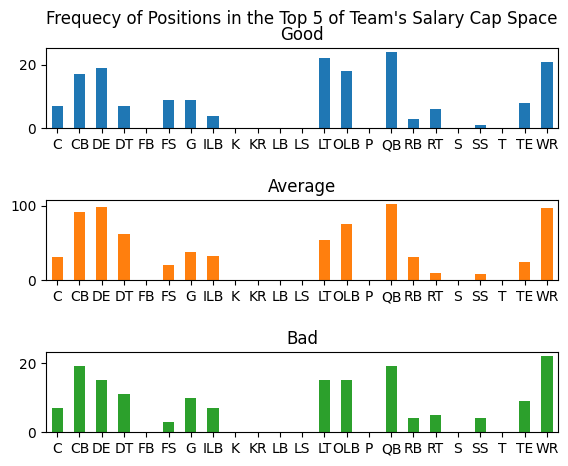

In [278]:
axes = pos_freq.plot.bar(rot=0, subplots=True, legend=None, sharex=False, title="Frequecy of Positions in the Top 5 of Team's Salary Cap Space")
fig.tight_layout(pad=5.0)
plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9,wspace=0.4,hspace=0.9)

Here we are trying to analyze if there is a difference in what positions, good, average, and bad teams play. This graph is showing the frequency that a position was in the top 5 for their respective team in terms of market cap percentage. From this graph, we see that there are a core group of positions that are valued higher than others. These positions are as follows: CB,DE,WR,LT,QB,OLB. Based on these findings, we will only analyze these positions statistics because it is apparent that NFL teams value them higher than others. 

QB, WR, CB, DE, OLB, G, and DT - these are the top positions from the overall league data. When looking at the separate groups, we notice that the LT position is clearly valued as important also. The rest of the positions seem to be closely in line with the league average. It also is worth mentioning that less of the time good teams pay DT compared to average and bad teams. 

### Significant Positions:
#### Offense: 
QB, WR, G, LT

#### Defense 
CB, DE, OLB, DT

Since we are going to be looking at the top paid player of each of these 8 positions, per season, per team, we need to make a DataFrame with those plays to later merge with the model.

In [279]:
#Josh explain why we are doing this with OLB

other_cap = salary_cap.copy(deep=True)
other_cap['pos'] = other_cap['pos'].replace({"LB":"OLB/DE", "ILB":"OLB/DE","DE":"OLB/DE"})

num = 14
for i in range(20-13):
    x = "cap_" + str(num) 
    globals()[x] = pd.DataFrame(other_cap)
    fullYr = int(str(20) + str(num))
    globals()[x] = globals()[x][globals()[x]["season"]==fullYr]
    num += 1

In [280]:
idx_list = []
for i in range(2000):
    idx_list.append(i) 

top8 = pd.DataFrame(index=idx_list, columns=["Player", "pos", "cap_percent", "season", "team", "cap_hit"])
important_pos = ["QB", "WR", "G", "LT", "CB","OLB/DE", "DT"]
season_years = [14, 15, 16, 17, 18, 19, 20]

yr = 14
x=0
for year in range(len(season_years)):
    
    lst = "team_list" + str(season_years[year])
    
    cap = "cap_" + str(season_years[year])
    
    for team in globals()[lst]:
        
        df = globals()[cap][globals()[cap]["team"]==team].sort_values(by = ["cap_percent"], ascending=False)
        df = df.drop_duplicates(subset=['pos'])
        df = df.reset_index()
        df = df.drop(columns=["index"])
        
        for i in range(len(df)):
    
            for pos in range(len(important_pos)):
                test = pd.DataFrame(columns=["Player", "pos", "cap_percent", "season", "team", "cap_hit"])
                
                if df['pos'].iloc[i] == important_pos[pos]:
                    test.loc[i] = df.iloc[i]
                    test = test.dropna()
                    
                    top8.iloc[x] = test.loc[i]
                    x += 1

top8 = top8.dropna()
top8 = top8.drop(columns=["cap_hit"])
top8.head()

,Player,pos,cap_percent,season,team
0,Carson Palmer,QB,9.57,2014,Arizona Cardinals
1,Calais Campbell,OLB/DE,8.28,2014,Arizona Cardinals
2,Larry Fitzgerald,WR,6.33,2014,Arizona Cardinals
3,Patrick Peterson,CB,5.11,2014,Arizona Cardinals
4,Jonathan Cooper,G,2.43,2014,Arizona Cardinals


In [281]:
top8[top8["team"]=="Los Vegas Raiders"]
# #IF YOU LOOK AT THIS CLOSE, YOU WILL SEE 2018 DOESN'T HAVE A LT

,Player,pos,cap_percent,season,team


In [282]:
tester = salary_cap[salary_cap["team"]=="Arizona Cardinals"]
tester = tester[tester["season"]==2018]
tester.sort_values(by="cap_percent", ascending=False)
tester = tester[tester['pos']=='T']
tester
#ALSO SHOWING 2018 DOESNT HAVE LT

,Player,pos,cap_hit,cap_percent,season,team
333,Will Holden,T,163235,0.09,2018,Arizona Cardinals
340,Rees Odhiambo,T,148236,0.08,2018,Arizona Cardinals


In [283]:
tester = salary_cap[salary_cap["team"]=="New York Giants"]
tester = tester[tester["season"]==2015]
tester.sort_values(by="cap_percent", ascending=False)
tester = tester[tester['pos']=='RT']
tester

,Player,pos,cap_hit,cap_percent,season,team
8176,Ereck Flowers,RT,2616676,1.82,2015,New York Giants
8234,Marshall Newhouse,RT,1300000,0.91,2015,New York Giants
8400,Bobby Hart,RT,452897,0.32,2015,New York Giants
8447,Emmett Cleary,RT,179117,0.12,2015,New York Giants


In [284]:
top8

,Player,pos,cap_percent,season,team
0,Carson Palmer,QB,9.57,2014,Arizona Cardinals
1,Calais Campbell,OLB/DE,8.28,2014,Arizona Cardinals
2,Larry Fitzgerald,WR,6.33,2014,Arizona Cardinals
3,Patrick Peterson,CB,5.11,2014,Arizona Cardinals
4,Jonathan Cooper,G,2.43,2014,Arizona Cardinals
...,...,...,...,...,...
1543,Ryan Kerrigan,OLB/DE,5.59,2020,Washington Football Team
1544,Kendall Fuller,CB,1.97,2020,Washington Football Team
1545,Da'Ron Payne,DT,1.88,2020,Washington Football Team
1546,Cornelius Lucas,LT,0.78,2020,Washington Football Team


In [285]:
# Josh trying to get all obersations to fix OLB issue

top8withWins = top8.merge(top5, on=["season", "team"], how='right')
top8withWins = top8withWins.drop(columns=["Player_y", "pos_y", "cap_percent_y"])
top8withWins = top8withWins.rename(columns={"Player_x":"Player", "pos_x":"pos", "cap_percent_x":"cap_percent"})
top8withWins.head(100)

,Player,pos,cap_percent,season,team,Season Wins
0,Carson Palmer,QB,9.57,2014,Arizona Cardinals,11.0
1,Calais Campbell,OLB/DE,8.28,2014,Arizona Cardinals,11.0
2,Larry Fitzgerald,WR,6.33,2014,Arizona Cardinals,11.0
3,Patrick Peterson,CB,5.11,2014,Arizona Cardinals,11.0
4,Jonathan Cooper,G,2.43,2014,Arizona Cardinals,11.0
...,...,...,...,...,...,...
95,Eugene Monroe,LT,2.43,2014,Baltimore Ravens,10.0
96,Chris Canty,OLB/DE,2.41,2014,Baltimore Ravens,10.0
97,Steve Smith,WR,1.65,2014,Baltimore Ravens,10.0
98,Joe Flacco,QB,11.25,2014,Baltimore Ravens,10.0


We have stats for each position group and their market cap %. Lets connect the two and create a new dataframe.

# ETL Part 2:

In [286]:
seasonCapWins = top5[['season',"team",'Season Wins']].copy()
seasonCapWins = seasonCapWins.drop_duplicates()
seasonCapWins

,season,team,Season Wins
0,2014,Arizona Cardinals,11.0
5,2014,Atlanta Falcons,6.0
10,2014,Baltimore Ravens,10.0
15,2014,Buffalo Bills,9.0
20,2014,Carolina Panthers,7.0
...,...,...,...
1095,2020,San Francisco 49ers,6.0
1100,2020,Seattle Seahawks,12.0
1105,2020,Tampa Bay Buccaneers,11.0
1110,2020,Tennessee Titans,11.0


In [287]:
cap_wins = other_cap.merge(seasonCapWins, on=["season", "team",], how='left')
cap_wins

,Player,pos,cap_hit,cap_percent,season,team,Season Wins
0,Lyle Sendlein,C,4125000,3.04,2014,Arizona Cardinals,11.0
1,Patrick Peterson,CB,6937132,5.11,2014,Arizona Cardinals,11.0
2,Jerraud Powers,CB,4750000,3.50,2014,Arizona Cardinals,11.0
3,Antonio Cromartie,CB,4000000,2.94,2014,Arizona Cardinals,11.0
4,Justin Bethel,CB,598556,0.44,2014,Arizona Cardinals,11.0
...,...,...,...,...,...,...,...
12129,Kelvin Harmon,WR,526960,0.27,2019,Washington Redskins,3.0
12130,Steven Sims Jr.,WR,500000,0.26,2019,Washington Redskins,3.0
12131,Cam Sims,WR,174705,0.09,2019,Washington Redskins,3.0
12132,Darvin Kidsy,WR,116472,0.06,2019,Washington Redskins,3.0


In [288]:
# Just check will delete in final version
cap_wins['pos'] = cap_wins['pos'].replace(['OLB'], 'OLB/DE')
cap_wins['pos'] = cap_wins['pos'].replace(['DE'], 'OLB/DE')
cap_wins[cap_wins["pos"]=='OLB/DE']

,Player,pos,cap_hit,cap_percent,season,team,Season Wins
5,Calais Campbell,OLB/DE,11250000,8.28,2014,Arizona Cardinals,11.0
6,Matt Shaughnessy,OLB/DE,1625000,1.20,2014,Arizona Cardinals,11.0
7,Alex Okafor,OLB/DE,613607,0.45,2014,Arizona Cardinals,11.0
8,Ed Stinson,OLB/DE,452920,0.33,2014,Arizona Cardinals,11.0
21,Deone Bucannon,OLB/DE,1401673,1.03,2014,Arizona Cardinals,11.0
...,...,...,...,...,...,...,...
12101,Josh Harvey-Clemons,OLB/DE,666076,0.34,2019,Washington Redskins,3.0
12102,Shaun-Dion Hamilton,OLB/DE,608252,0.31,2019,Washington Redskins,3.0
12104,Cole Holcomb,OLB/DE,553721,0.29,2019,Washington Redskins,3.0
12106,Montez Sweat,OLB/DE,2116593,1.09,2019,Washington Redskins,3.0


#### Scraping to create table 5:

We now need to scrape in each positions statistics for seasons 2014-2020. We found the site "https://www.pro-football-reference.com/" that has season stats for each position. It has stats like, total sacks, QB pressures, Passes Defended, passing touchdowns, interceptions, etc. We will scrape this data into a dataframe. It has unnecessary stats such as fumbles recovered for touchdowns and yards gained after an interception, therefore we need to do some cleanup work to make it more useful to our overall goal. It also only has abbreviations of teams names so we will need to correct that issue so we can merge this dataframe with our Salary Cap dataframe.

# Defense WebScraper

In [289]:
#WEB-SCRAPING FOR LOOP RESPONSIBLE FOR DEFENSIVE POSITIONS

years = [2014,2015,2016,2017,2018,2019,2020]
df_list = []
for y in years:
    
    url = 'https://www.pro-football-reference.com/years/' + str(y) + '/defense.htm'
    headers = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10_1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/39.0.2171.95 Safari/537.36'}

    b = requests.get(url, headers=headers)
    soup = BeautifulSoup(b.content)
    table = soup.find("table")
    table_df = pd.read_html(str(table))[0]
    
    table_df = table_df.fillna(value=0)
    table_df.columns = table_df.columns.droplevel()
    table_df["season"]=y
    
    table_df = table_df.drop(columns=["Yds", "TD", "Lng", "Fmb", "Sfty","Rk"])
    table_df = table_df.rename(columns={"Tm":"Team", "Pos":"pos", "G":"Played", "GS":"Started", "PD":"Pass Def", "Sk":"Sack"})
    table_df["Player"] = table_df["Player"].apply(lambda x: x.replace("*","").replace("+","")) 
    
     
    if (y<=2015):
        table_df["Team"] = table_df["Team"].map({
    "HOU": "Houston Texans", "CHI": "Chicago Bears", "TAM": "Tampa Bay Buccaneers",
    "NYJ": "New York Jets", "NYG": "New York Giants", "BUF": "Buffalo Bills",
    "ARI":"Arizona Cardinals", "DAL": "Dallas Cowboys","TEN": "Tennessee Titans",
    "IND": "Indianapolis Colts","JAX": "Jacksonville Jaguars","SEA": "Seattle Seahawks",
    "SFO": "San Francisco 49ers","CIN": "Cincinnati Bengals","ATL": "Atlanta Falcons",
    "DEN": "Denver Broncos", "NWE": "New England Patriots","PHI": "Philadelphia Eagles",
    "NOR": "New Orleans Saints","STL": "St. Louis Rams","MIN": "Minnesota Vikings",
    "CAR": "Carolina Panthers","KAN": "Kansas City Chiefs", "SD": "San Diego Chargers",
    "BAL": "Baltimore Ravens","GNB": "Green Bay Packers", "MIA": "Miami Dolphins",
    "DET": "Detroit Lions", "WAS": "Washington Redskins","OAK": "Oakland Raiders",
    "PIT": "Pittsburgh Steelers", "CLE": "Cleveland Browns"})
            
    if (y==2016):
        table_df["Team"] = table_df["Team"].map({
    "HOU": "Houston Texans", "CHI": "Chicago Bears", "TAM": "Tampa Bay Buccaneers",
    "NYJ": "New York Jets", "NYG": "New York Giants", "BUF": "Buffalo Bills",
    "ARI":"Arizona Cardinals", "DAL": "Dallas Cowboys","TEN": "Tennessee Titans",
    "IND": "Indianapolis Colts","JAX": "Jacksonville Jaguars","SEA": "Seattle Seahawks",
    "SFO": "San Francisco 49ers","CIN": "Cincinnati Bengals","ATL": "Atlanta Falcons",
    "DEN": "Denver Broncos", "NWE": "New England Patriots","PHI": "Philadelphia Eagles",
    "NOR": "New Orleans Saints","LAR": "Los Angeles Rams","MIN": "Minnesota Vikings",
    "CAR": "Carolina Panthers","KAN": "Kansas City Chiefs", "SD": "San Diego Chargers",
    "BAL": "Baltimore Ravens","GNB": "Green Bay Packers", "MIA": "Miami Dolphins",
    "DET": "Detroit Lions", "WAS": "Washington Redskins","OAK": "Oakland Raiders",
    "PIT": "Pittsburgh Steelers", "CLE": "Cleveland Browns"})
            
    
    if y>2016 and y<2020: 
        table_df["Team"] = table_df["Team"].map({
    "HOU": "Houston Texans", "CHI": "Chicago Bears", "TAM": "Tampa Bay Buccaneers",
    "NYJ": "New York Jets", "NYG": "New York Giants", "BUF": "Buffalo Bills",
    "ARI":"Arizona Cardinals", "DAL": "Dallas Cowboys","TEN": "Tennessee Titans",
    "IND": "Indianapolis Colts","JAX": "Jacksonville Jaguars","SEA": "Seattle Seahawks",
    "SFO": "San Francisco 49ers","CIN": "Cincinnati Bengals","ATL": "Atlanta Falcons",
    "DEN": "Denver Broncos", "NWE": "New England Patriots","PHI": "Philadelphia Eagles",
    "NOR": "New Orleans Saints","LAR": "Los Angeles Rams","MIN": "Minnesota Vikings",
    "CAR": "Carolina Panthers","KAN": "Kansas City Chiefs", "LAC": "Los Angeles Chargers",
    "BAL": "Baltimore Ravens","GNB": "Green Bay Packers", "MIA": "Miami Dolphins",
    "DET": "Detroit Lions", "WAS": "Washington Redskins","OAK": "Oakland Raiders",
    "PIT": "Pittsburgh Steelers", "CLE": "Cleveland Browns"})
            
    if (y==2020):     
        table_df["Team"] = table_df["Team"].map({
    "HOU": "Houston Texans", "CHI": "Chicago Bears", "TAM": "Tampa Bay Buccaneers",
    "NYJ": "New York Jets", "NYG": "New York Giants", "BUF": "Buffalo Bills",
    "ARI":"Arizona Cardinals", "DAL": "Dallas Cowboys","TEN": "Tennessee Titans",
    "IND": "Indianapolis Colts","JAX": "Jacksonville Jaguars","SEA": "Seattle Seahawks",
    "SFO": "San Francisco 49ers","CIN": "Cincinnati Bengals","ATL": "Atlanta Falcons",
    "DEN": "Denver Broncos", "NWE": "New England Patriots","PHI": "Philadelphia Eagles",
    "NOR": "New Orleans Saints","LAR": "Los Angeles Rams","MIN": "Minnesota Vikings",
    "CAR": "Carolina Panthers","KAN": "Kansas City Chiefs", "LAC": "Los Angeles Chargers",
    "BAL": "Baltimore Ravens","GNB": "Green Bay Packers", "MIA": "Miami Dolphins",
    "DET": "Detroit Lions", "WAS": "Washington Football Team","LVR": "Las Vegas Raiders",
    "PIT": "Pittsburgh Steelers", "CLE": "Cleveland Browns"})
    
    table_df = table_df.rename(columns={"Team":"team"})
    df_list.append(table_df)

The above code's purpose is to make a DataFrame with defense stats from 2014 to 2020, while making a new data frame for each season. (defense14, defense15... etc.) Finally, one final data frame titled 'defense' was made, containing all of this data. This was done so that we could merge this with the data frame containing the top 5 paid players from each team, from each season. Doing this, we will make seperate data frames for each position, and by making a regressor model with the seasonal statistics that we've scraped from above, the model will be able to predict the amount of wins a given player will get in a season, with x, y, and z statistics.

Our issue as of now, which you will see below, is that the webscraping didn't fully work. While the index shows over 1000 observations, we only have 750. Therefore, when we attempted to merge the data with the top5 data set on players, it didn't work correctly. Along with creating a successful and accurate model, this is a priority for us to work on in Milestone 3.

In [290]:
defense = pd.concat(df_list)
defense.head()

,Player,team,Age,pos,Played,Started,Int,Pass Def,FF,FR,Sack,Comb,Solo,Ast,TFL,QBHits,season
0,DeAndre Levy,Detroit Lions,27,RLB,16,16,1,4,0,0,2.5,151,117,34,16,4,2014
1,Lavonte David,Tampa Bay Buccaneers,24,RLB,14,14,0,4,4,1,1.0,146,101,45,17,4,2014
2,Luke Kuechly,Carolina Panthers,23,MLB,16,16,1,12,1,1,3.0,153,99,54,9,4,2014
3,Curtis Lofton,New Orleans Saints,28,RILB,16,16,0,1,1,1,0.0,144,99,45,5,4,2014
4,Morgan Burnett,Green Bay Packers,25,SS,15,15,1,4,1,1,1.5,130,94,36,4,3,2014


In [291]:
#A PROBLEM COMES UP WHEN WEBSCRAPING FROM THIS PARTICULAR SOURCE: IN THE TABLE, EVERY 20-30 ROWS, 
# THERE IS A REPEATED LABEL ROW, WHICH NEEDS TO BE DELETED FROM THE DF
# THEY LOOK LIKE THIS
defense[defense["Played"]=="G"].head()

,Player,team,Age,pos,Played,Started,Int,Pass Def,FF,FR,Sack,Comb,Solo,Ast,TFL,QBHits,season
29,Player,NaN,Age,Pos,G,GS,Int,PD,FF,FR,Sk,Comb,Solo,Ast,TFL,QBHits,2014
60,Player,NaN,Age,Pos,G,GS,Int,PD,FF,FR,Sk,Comb,Solo,Ast,TFL,QBHits,2014
91,Player,NaN,Age,Pos,G,GS,Int,PD,FF,FR,Sk,Comb,Solo,Ast,TFL,QBHits,2014
122,Player,NaN,Age,Pos,G,GS,Int,PD,FF,FR,Sk,Comb,Solo,Ast,TFL,QBHits,2014
153,Player,NaN,Age,Pos,G,GS,Int,PD,FF,FR,Sk,Comb,Solo,Ast,TFL,QBHits,2014


In [292]:
#Removing NULL/Labeling Observations/Rows. 308 of them have to be removed
lenDEF = len(defense)
gs = defense["Played"].value_counts()["G"]
print("Original length of defense is " + str(lenDEF) + ". There are " + str(gs) + " null rows in this DF. Therefore, \nif done correctly, the final\nlength of 'defense' should be: " + str(lenDEF-gs))     

Original length of defense is 9639. There are 308 null rows in this DF. Therefore, 
if done correctly, the final
length of 'defense' should be: 9331


In [293]:
delete = defense[defense['Played']=='G']
defense = defense.drop(delete.index)
print("Now, 'defense' DF length is: " + str(len(defense)) +"! We've successfully removed all of the null rows.")

Now, 'defense' DF length is: 9331! We've successfully removed all of the null rows.


The dtypes are not correct so we will update them.

In [294]:
#CHECKING DTYPES
def_cols = ['Age', 'Played','Started','Int','Pass Def','FF','FR','Sack','Comb','Solo','Ast','TFL','QBHits']
defense[def_cols] = defense[def_cols].apply(pd.to_numeric)

Dtypes are now good to go

In [295]:
#Generalizing 

DEF_dict = {"LB": "OLB/DE","ROLB/LIL": "OLB/DE","ROLB/RIL": "OLB/DE","LOLB": "OLB/DE","ROLB": "OLB/DE","ROLB/LOL": "OLB/DE","LB-ROLB": "OLB/DE","OLB": "OLB/DE","LLB-ROLB": "OLB/DE","LB-LDE":"OLB/DE","RDE/LOLB": "OLB/DE","DE-LOLB": "OLB/DE","DE-ROLB": "OLB/DE","LDE": "OLB/DE","RDE": "OLB/DE","DE": "OLB/DE","LDE/RDE": "OLB/DE","DE-RDE": "OLB/DE","RDE/LDE": "OLB/DE","LDE/LDT": "OLB/DE","LDE/NT": "OLB/DE","RDE/LDT": "OLB/DE","DE/DT": "OLB/DE","RCB": "CB","LCB": "CB","DB-LCB": "CB", "DB-RCB/L": "CB","DB-RCB": "CB","LCB/RCB": "CB","CB": "CB","CB/SS": "CB","CB-DB": "CB","RCB/LCB": "CB","RCB/DB": "CB","RCB/FS": "CB","RCB/SS": "CB","LCB/FS": "CB","DT-RDE": "DT","DT/DE": "DT", "RDT": "DT","LDT": "DT","DT": "DT", "LDT/RDT": "DT", "DT-FB": "DT", "NT-RDT": "DT", "RDT/LDT": "DT", "DT-NT": "DT"}


defense["pos"] = defense["pos"].map(DEF_dict)

In [296]:
defense['pos'].value_counts()

OLB/DE    2302
DT         824
CB         592
Name: pos, dtype: int64

In [297]:
DE_df = defense[defense["pos"]=="DE"]
DT_df = defense[defense["pos"]=="DT"]
CB_df = defense[defense["pos"]=="CB"]
OLB_df = defense[defense["pos"]=="OLB"]
OLB_DE_df = defense[(defense["pos"]=="OLB/DE")]
#display(cap_wins.loc[(cap_wins['pos']=='LT') | (cap_wins['pos']=="T") | (cap_wins['pos']=="RT")])

In [298]:
OLB_DE_df

,Player,team,Age,pos,Played,Started,Int,Pass Def,FF,FR,Sack,Comb,Solo,Ast,TFL,QBHits,season
73,Justin Houston,Kansas City Chiefs,25,OLB/DE,16,16,0,5,4,0,22.0,69,60,9,23,25,2014
82,J.J. Watt,Houston Texans,25,OLB/DE,16,16,1,10,4,5,20.5,78,59,19,29,51,2014
105,Jason Pierre-Paul,New York Giants,25,OLB/DE,16,16,0,6,3,1,12.5,76,54,22,16,21,2014
111,Wesley Woodyard,Tennessee Titans,28,OLB/DE,16,16,2,3,0,0,2.5,94,53,41,6,6,2014
125,Ryan Kerrigan,Washington Redskins,26,OLB/DE,16,16,0,1,5,1,13.5,64,51,13,18,19,2014
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1337,Nate Orchard,Washington Football Team,27,OLB/DE,3,0,0,0,0,0,0.0,2,0,2,0,0,2020
1367,Brady Sheldon,New York Jets,27,OLB/DE,2,0,0,0,0,0,0.0,1,0,1,0,0,2020
1375,Terrance Smith,Arizona Cardinals,27,OLB/DE,3,0,0,0,0,0,0.0,2,0,2,0,0,2020
1387,Solomon Thomas,San Francisco 49ers,25,OLB/DE,2,2,0,0,0,0,0.0,2,0,2,0,0,2020


In [299]:
cap_wins.head(2)

,Player,pos,cap_hit,cap_percent,season,team,Season Wins
0,Lyle Sendlein,C,4125000,3.04,2014,Arizona Cardinals,11.0
1,Patrick Peterson,CB,6937132,5.11,2014,Arizona Cardinals,11.0


In [300]:
OLB_DE_df = OLB_DE_df.rename(columns={"pox":"pos"})
OLB_DE_df.head(2)

,Player,team,Age,pos,Played,Started,Int,Pass Def,FF,FR,Sack,Comb,Solo,Ast,TFL,QBHits,season
73,Justin Houston,Kansas City Chiefs,25,OLB/DE,16,16,0,5,4,0,22.0,69,60,9,23,25,2014
82,J.J. Watt,Houston Texans,25,OLB/DE,16,16,1,10,4,5,20.5,78,59,19,29,51,2014


In [428]:
# ***SOMETHING IS GOING WRONG WITH THIS MERGE***
DTs = cap_wins.merge(DT_df, on=["Player", "season", "pos",], how='inner')
DTs = DTs.drop(columns=["team_y"])
DTs = DTs.rename(columns={"team_x":"team"})
CBs = cap_wins.merge(CB_df, on=["Player", "season", "pos"], how='inner')
CBs = CBs.drop(columns=["team_y"])
CBs = CBs.rename(columns={"team_x":"team"})
OLBs_DEs = cap_wins.merge(OLB_DE_df, on=["Player", "season",'pos'], how='inner')
OLBs_DEs = OLBs_DEs.rename(columns={"Season Wins_x	":"Season Wins"})
OLBs_DEs = OLBs_DEs.drop(columns=["team_y"])
OLBs_DEs = OLBs_DEs.rename(columns={"team_x":"team"})
OLBs_DEs


,Player,pos,cap_hit,cap_percent,season,team,Season Wins,Age,Played,Started,Int,Pass Def,FF,FR,Sack,Comb,Solo,Ast,TFL,QBHits
0,Calais Campbell,OLB/DE,11250000,8.28,2014,Arizona Cardinals,11.0,28,14,14,1,3,1,0,7.0,58,48,10,16,11
1,Matt Shaughnessy,OLB/DE,1625000,1.20,2014,Arizona Cardinals,11.0,28,8,7,0,0,0,0,0.0,17,12,5,3,0
2,Alex Okafor,OLB/DE,613607,0.45,2014,Arizona Cardinals,11.0,23,13,12,1,3,0,0,8.0,30,28,2,11,13
3,Ed Stinson,OLB/DE,452920,0.33,2014,Arizona Cardinals,11.0,24,10,2,0,1,0,0,0.0,9,6,3,0,3
4,Kenny Demens,OLB/DE,495000,0.36,2014,Arizona Cardinals,11.0,24,14,0,0,0,1,0,0.0,9,9,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1700,Matthew Ioannidis,OLB/DE,2525000,1.30,2019,Washington Redskins,3.0,25,16,15,0,1,0,0,8.5,64,42,22,11,16
1701,Nate Orchard,OLB/DE,236765,0.12,2019,Washington Redskins,3.0,26,5,0,0,1,0,1,1.0,14,8,6,2,2
1702,Chris Odom,OLB/DE,167647,0.09,2019,Washington Redskins,3.0,25,4,0,0,0,1,0,2.0,10,9,1,1,2
1703,Montez Sweat,OLB/DE,2116593,1.09,2019,Washington Redskins,3.0,23,16,16,0,2,2,0,7.0,50,31,19,8,13


In [429]:
# Not needed - used for josh to try to solve where missing data is 
OLB_df[OLB_df['pos']=='OLB']
display(OLB_df.loc[(OLB_df['pos']=='OLB') & (OLB_df['team'] == 'Arizona Cardinals')])

# was looking to see if I could locate Deone Bucannon (from the cap_wins df) but could not in OLB_df

,Player,team,Age,pos,Played,Started,Int,Pass Def,FF,FR,Sack,Comb,Solo,Ast,TFL,QBHits,season


In [430]:
#Not needed for final product can be deleted
# issue located - Deone Bucannon pos is NaN
defense[defense["Player"]=="Deone Bucannon"] # # listed as NaN
defense[defense["Player"]=="Osi Umenyiora"] # listed as DE

,Player,team,Age,pos,Played,Started,Int,Pass Def,FF,FR,Sack,Comb,Solo,Ast,TFL,QBHits,season
687,Osi Umenyiora,Atlanta Falcons,33,OLB/DE,16,0,0,1,0,1,2.5,12,9,3,2,9,2014


In [431]:
#not needed for final can be deleted 
#seeing how many positions are listed as Nan in Defense DF
defense['pos'].isnull().values.sum()

5613

In [432]:
#not needed for final can be deleted 
defense[defense['pos'].isna()]

,Player,team,Age,pos,Played,Started,Int,Pass Def,FF,FR,Sack,Comb,Solo,Ast,TFL,QBHits,season
0,DeAndre Levy,Detroit Lions,27,NaN,16,16,1,4,0,0,2.5,151,117,34,16,4,2014
1,Lavonte David,Tampa Bay Buccaneers,24,NaN,14,14,0,4,4,1,1.0,146,101,45,17,4,2014
2,Luke Kuechly,Carolina Panthers,23,NaN,16,16,1,12,1,1,3.0,153,99,54,9,4,2014
3,Curtis Lofton,New Orleans Saints,28,NaN,16,16,0,1,1,1,0.0,144,99,45,5,4,2014
4,Morgan Burnett,Green Bay Packers,25,NaN,15,15,1,4,1,1,1.5,130,94,36,4,3,2014
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1403,Jeff Wilson,San Francisco 49ers,25,NaN,12,3,0,0,0,1,0.0,0,0,0,0,0,2020
1404,Javon Wims,Chicago Bears,26,NaN,13,1,0,0,0,0,0.0,1,0,1,0,0,2020
1405,Isaiah Wynn,New England Patriots,25,NaN,10,10,0,0,0,1,0.0,0,0,0,0,0,2020
1406,T.J. Yeldon,Buffalo Bills,27,NaN,3,0,0,0,0,1,0.0,0,0,0,0,0,2020


# OLB/DE Linear Regression Model

In [433]:
#Choosing test features
OLBs_DEsfeats = ['Age', 'Played', 'Started', 'Int', 'Pass Def', 'FF', 'FR','Sack', 'Comb', 'Solo', 'Ast', 'TFL', 'QBHits']
#Assigning X (features/attributes)
x = OLBs_DEs[OLBs_DEsfeats]
#Assigning Y (label/predicted val)
y = OLBs_DEs['Season Wins']


#Split the data into training and test sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.5, random_state=10)

#Standardizing the data
scaler = StandardScaler()
scaler.fit(x_train)
x_train_sc = scaler.transform(x_train)
x_test_sc = scaler.transform(x_test)


#Setting up Linear Regression Model
linReg = LinearRegression()
linReg.fit(x_train_sc, y_train)

#Letting model make prediction
y_test_pred = linReg.predict(x_test_sc)
y_train_pred = linReg.predict(x_train_sc)


#Checking MAE, MSE, and RMSE
vMAE = (metrics.mean_absolute_error(y_test, y_test_pred))
tMAE = (metrics.mean_absolute_error(y_train, y_train_pred))
cMAE = np.mean(-cross_val_score(linReg, x, y, cv=5, scoring="neg_mean_absolute_error"))


vMSE = (metrics.mean_squared_error(y_test, y_test_pred))
tMSE = (metrics.mean_squared_error(y_train, y_train_pred))
cross_val_mse = np.mean(-cross_val_score(linReg, x, y, cv=5, scoring="neg_mean_squared_error"))

vRMSE = math.sqrt(vMSE)
tRMSE = math.sqrt(tMSE)
cRMSE = math.sqrt(cross_val_mse)

print("Testing MAE:")
print(tMAE)
print("\n")

print("5-Fold Cross Validation MAE:")
print(cMAE)
print("\n")

print("Testing RMSE:")
print(tRMSE)
print("\n")

print("5-Fold Cross Validation RMSE:")
print(cRMSE)

Testing MAE:
2.5654278926005105


5-Fold Cross Validation MAE:
2.5993656216342536


Testing RMSE:
3.0677171057777364


5-Fold Cross Validation RMSE:
3.096108103823313


In [434]:
OLBDEdrop = ['cap_hit','pos', 'Age', 'Played', 'Started', 'Int', 'Pass Def', 'FF', 'FR','Sack', 'Comb', 'Solo', 'Ast', 'TFL', 'QBHits']

In [435]:
OLBDE_Train = OLBs_DEs.loc[y_train.index]
OLBDE_Train = OLBDE_Train.drop(columns = OLBDEdrop)
OLBDE_Train
OLBDE_Train["Predicted Wins"] = y_train_pred
#____________________________________________________________________________________________________________________________
#CHECK WITH PROF IF IT IS AN ISSUE TO DO THIS. I NEED THESE OBSERVATIONS FOR MODEL 2, BUT I AM NOT SURE HOW TO GET THEM WITHOUT THE MODEL ALREADY SEEING THEM
OLBDE_Test = OLBs_DEs.loc[y_test.index]
OLBDE_Test = OLBDE_Test.drop(columns = OLBDEdrop)
OLBDE_Test
OLBDE_Test["Predicted Wins"] = y_test_pred


predictedOLBDEs = pd.concat([OLBDE_Test, OLBDE_Train])
predictedOLBDEs['pos']='OLB/DE'
predictedOLBDEs

,Player,cap_percent,season,team,Season Wins,Predicted Wins,pos
318,Barkevious Mingo,0.42,2020,Chicago Bears,8.0,7.494192,OLB/DE
1309,Connor Barwin,4.55,2016,Philadelphia Eagles,7.0,7.717217,OLB/DE
1042,Ifeadi Odenigbo,0.41,2020,Minnesota Vikings,7.0,7.597560,OLB/DE
1272,Khalil Mack,3.41,2017,Oakland Raiders,6.0,7.400157,OLB/DE
1068,Trey Flowers,0.45,2017,New England Patriots,13.0,7.110524,OLB/DE
...,...,...,...,...,...,...,...
1393,Anthony Chickillo,0.92,2019,Pittsburgh Steelers,8.0,7.479763,OLB/DE
1344,Clifton Geathers,0.13,2014,Pittsburgh Steelers,11.0,7.636113,OLB/DE
527,Austin Calitro,0.32,2020,Denver Broncos,5.0,8.052176,OLB/DE
1149,Jason Pierre-Paul,5.13,2015,New York Giants,6.0,7.982096,OLB/DE


In [436]:
predictedOLBDEs_top8 = top8[top8['pos']=='OLB/DE']
predictedOLBDEs_top8
predictedOLBDEs_top8 = predictedOLBDEs_top8.merge(predictedOLBDEs, on=["Player","pos", "season","cap_percent",'team'], how='left')
predictedOLBDEs_top8


,Player,pos,cap_percent,season,team,Season Wins,Predicted Wins
0,Calais Campbell,OLB/DE,8.28,2014,Arizona Cardinals,11.0,8.234475
1,Tyson Jackson,OLB/DE,2.33,2014,Atlanta Falcons,NaN,NaN
2,Chris Canty,OLB/DE,2.41,2014,Baltimore Ravens,10.0,7.032174
3,Mario Williams,OLB/DE,12.48,2014,Buffalo Bills,9.0,8.369924
4,Charles Johnson,OLB/DE,8.09,2014,Carolina Panthers,7.0,8.307547
...,...,...,...,...,...,...,...
219,Arik Armstead,OLB/DE,2.9,2020,San Francisco 49ers,6.0,7.170951
220,Bobby Wagner,OLB/DE,7.39,2020,Seattle Seahawks,NaN,NaN
221,Lavonte David,OLB/DE,5.27,2020,Tampa Bay Buccaneers,NaN,NaN
222,Rashaan Evans,OLB/DE,1.43,2020,Tennessee Titans,NaN,NaN


In [437]:
predictedOLBDEs_top8[predictedOLBDEs_top8['Predicted Wins'].isna()]

,Player,pos,cap_percent,season,team,Season Wins,Predicted Wins
1,Tyson Jackson,OLB/DE,2.33,2014,Atlanta Falcons,NaN,NaN
7,Karlos Dansby,OLB/DE,3.51,2014,Cleveland Browns,NaN,NaN
8,Bruce Carter,OLB/DE,1.15,2014,Dallas Cowboys,NaN,NaN
12,Brian Cushing,OLB/DE,4.27,2014,Houston Texans,NaN,NaN
13,D'Qwell Jackson,OLB/DE,3.56,2014,Indianapolis Colts,NaN,NaN
...,...,...,...,...,...,...,...
213,Lawrence Guy,OLB/DE,2.78,2020,New England Patriots,NaN,NaN
215,Leonard Williams,OLB/DE,8.17,2020,New York Giants,NaN,NaN
220,Bobby Wagner,OLB/DE,7.39,2020,Seattle Seahawks,NaN,NaN
221,Lavonte David,OLB/DE,5.27,2020,Tampa Bay Buccaneers,NaN,NaN


In [438]:
top8['pos'].value_counts()

QB        224
OLB/DE    224
WR        224
CB        224
DT        224
G         222
LT        206
Name: pos, dtype: int64

# QB WebScraper

In [311]:
#WEB-SCRAPING FOR LOOP RESPONSIBLE FOR QUARTERBACKS

years = [2014,2015,2016,2017,2018,2019,2020]
QB_list = []
for y in years:
    
    url = 'https://www.pro-football-reference.com/years/' + str(y) + '/passing.htm'
    headers = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10_1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/39.0.2171.95 Safari/537.36'}

    b = requests.get(url, headers=headers)
    soup = BeautifulSoup(b.content)
    table = soup.find("table")
    table_df = pd.read_html(str(table))[0]
    
    table_df = table_df.fillna(value=0)
    table_df["season"]=y
    
    table_df = table_df.drop(columns=["Rk",])
    table_df = table_df.rename(columns={"Tm":"Team", "Pos":"pos","G":"Played", "GS":"Started", "Cmp":"Completed", "Att":"Attempted", "Sk":"Times Sacked", "Yds.1":"Sacked -Yards"})
    table_df["Player"] = table_df["Player"].apply(lambda x: x.replace("*","").replace("+","")) 
    

    if (y<=2015):
        table_df["Team"] = table_df["Team"].map({
    "HOU": "Houston Texans", "CHI": "Chicago Bears", "TAM": "Tampa Bay Buccaneers",
    "NYJ": "New York Jets", "NYG": "New York Giants", "BUF": "Buffalo Bills",
    "ARI":"Arizona Cardinals", "DAL": "Dallas Cowboys","TEN": "Tennessee Titans",
    "IND": "Indianapolis Colts","JAX": "Jacksonville Jaguars","SEA": "Seattle Seahawks",
    "SFO": "San Francisco 49ers","CIN": "Cincinnati Bengals","ATL": "Atlanta Falcons",
    "DEN": "Denver Broncos", "NWE": "New England Patriots","PHI": "Philadelphia Eagles",
    "NOR": "New Orleans Saints","STL": "St. Louis Rams","MIN": "Minnesota Vikings",
    "CAR": "Carolina Panthers","KAN": "Kansas City Chiefs", "SD": "San Diego Chargers",
    "BAL": "Baltimore Ravens","GNB": "Green Bay Packers", "MIA": "Miami Dolphins",
    "DET": "Detroit Lions", "WAS": "Washington Redskins","OAK": "Oakland Raiders",
    "PIT": "Pittsburgh Steelers", "CLE": "Cleveland Browns"})
            
    if (y==2016):
        table_df["Team"] = table_df["Team"].map({
    "HOU": "Houston Texans", "CHI": "Chicago Bears", "TAM": "Tampa Bay Buccaneers",
    "NYJ": "New York Jets", "NYG": "New York Giants", "BUF": "Buffalo Bills",
    "ARI":"Arizona Cardinals", "DAL": "Dallas Cowboys","TEN": "Tennessee Titans",
    "IND": "Indianapolis Colts","JAX": "Jacksonville Jaguars","SEA": "Seattle Seahawks",
    "SFO": "San Francisco 49ers","CIN": "Cincinnati Bengals","ATL": "Atlanta Falcons",
    "DEN": "Denver Broncos", "NWE": "New England Patriots","PHI": "Philadelphia Eagles",
    "NOR": "New Orleans Saints","LAR": "Los Angeles Rams","MIN": "Minnesota Vikings",
    "CAR": "Carolina Panthers","KAN": "Kansas City Chiefs", "SD": "San Diego Chargers",
    "BAL": "Baltimore Ravens","GNB": "Green Bay Packers", "MIA": "Miami Dolphins",
    "DET": "Detroit Lions", "WAS": "Washington Redskins","OAK": "Oakland Raiders",
    "PIT": "Pittsburgh Steelers", "CLE": "Cleveland Browns"})
            
    if y>2016 and y<2020: 
        table_df["Team"] = table_df["Team"].map({
    "HOU": "Houston Texans", "CHI": "Chicago Bears", "TAM": "Tampa Bay Buccaneers",
    "NYJ": "New York Jets", "NYG": "New York Giants", "BUF": "Buffalo Bills",
    "ARI":"Arizona Cardinals", "DAL": "Dallas Cowboys","TEN": "Tennessee Titans",
    "IND": "Indianapolis Colts","JAX": "Jacksonville Jaguars","SEA": "Seattle Seahawks",
    "SFO": "San Francisco 49ers","CIN": "Cincinnati Bengals","ATL": "Atlanta Falcons",
    "DEN": "Denver Broncos", "NWE": "New England Patriots","PHI": "Philadelphia Eagles",
    "NOR": "New Orleans Saints","LAR": "Los Angeles Rams","MIN": "Minnesota Vikings",
    "CAR": "Carolina Panthers","KAN": "Kansas City Chiefs", "LAC": "Los Angeles Chargers",
    "BAL": "Baltimore Ravens","GNB": "Green Bay Packers", "MIA": "Miami Dolphins",
    "DET": "Detroit Lions", "WAS": "Washington Redskins","OAK": "Oakland Raiders",
    "PIT": "Pittsburgh Steelers", "CLE": "Cleveland Browns"})
            
    if (y==2020):     
        table_df["Team"] = table_df["Team"].map({
    "HOU": "Houston Texans", "CHI": "Chicago Bears", "TAM": "Tampa Bay Buccaneers",
    "NYJ": "New York Jets", "NYG": "New York Giants", "BUF": "Buffalo Bills",
    "ARI":"Arizona Cardinals", "DAL": "Dallas Cowboys","TEN": "Tennessee Titans",
    "IND": "Indianapolis Colts","JAX": "Jacksonville Jaguars","SEA": "Seattle Seahawks",
    "SFO": "San Francisco 49ers","CIN": "Cincinnati Bengals","ATL": "Atlanta Falcons",
    "DEN": "Denver Broncos", "NWE": "New England Patriots","PHI": "Philadelphia Eagles",
    "NOR": "New Orleans Saints","LAR": "Los Angeles Rams","MIN": "Minnesota Vikings",
    "CAR": "Carolina Panthers","KAN": "Kansas City Chiefs", "LAC": "Los Angeles Chargers",
    "BAL": "Baltimore Ravens","GNB": "Green Bay Packers", "MIA": "Miami Dolphins",
    "DET": "Detroit Lions", "WAS": "Washington Football Team","LVR": "Las Vegas Raiders",
    "PIT": "Pittsburgh Steelers", "CLE": "Cleveland Browns"})
    
    table_df = table_df.rename(columns={"Team":"team"})
    QB_list.append(table_df)

In [312]:
QB_df = pd.concat(QB_list)
QB_df = QB_df[QB_df["pos"]=="QB"]
cols = ['Age','Played', 'Started','Completed', 'Attempted', 'Cmp%', 'Yds', 'TD', 'TD%', 'Int', 'Int%','1D', 'Lng', 'Y/A', 'AY/A', 'Y/C', 'Y/G', 'Rate', 'QBR', 'Times Sacked','Sacked -Yards', 'Sk%', 'NY/A', 'ANY/A', '4QC', 'GWD', 'season']
QB_df[cols] = QB_df[cols].apply(pd.to_numeric)

In [313]:
QB_df

,Player,team,Age,pos,Played,Started,QBrec,Completed,Attempted,Cmp%,...,Rate,QBR,Times Sacked,Sacked -Yards,Sk%,NY/A,ANY/A,4QC,GWD,season
0,Drew Brees,New Orleans Saints,35,QB,16,16,7-9-0,456,659,69.2,...,97.0,73.2,29,186,4.2,6.93,6.77,2,2,2014
1,Ben Roethlisberger,Pittsburgh Steelers,32,QB,16,16,11-5-0,408,608,67.1,...,103.3,69.4,33,172,5.1,7.46,7.82,2,3,2014
2,Andrew Luck,Indianapolis Colts,25,QB,16,16,11-5-0,380,616,61.7,...,96.5,64.0,27,161,4.2,7.15,7.28,1,1,2014
3,Peyton Manning,Denver Broncos,38,QB,16,16,12-4-0,395,597,66.2,...,101.5,72.6,17,118,2.8,7.51,7.68,1,1,2014
4,Matt Ryan,Atlanta Falcons,29,QB,16,16,6-10-0,415,628,66.1,...,93.9,66.8,31,205,4.7,6.81,6.71,3,3,2014
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90,Jacoby Brissett,Indianapolis Colts,28,QB,11,0,0,2,8,25.0,...,39.6,58.3,2,15,20.0,0.20,0.20,0,0,2020
93,Tyler Huntley,Baltimore Ravens,22,QB,2,0,0,3,5,60.0,...,64.6,1.4,0,0,0.0,3.00,3.00,0,0,2020
100,Logan Woodside,Tennessee Titans,25,QB,6,0,0,1,3,33.3,...,42.4,65.1,0,0,0.0,2.33,2.33,0,0,2020
102,Easton Stick,Los Angeles Chargers,25,QB,1,0,0,1,1,100.0,...,83.3,1.3,0,0,0.0,4.00,4.00,0,0,2020


In [314]:
cap_wins[cap_wins["pos"]=="QB"]

,Player,pos,cap_hit,cap_percent,season,team,Season Wins
34,Carson Palmer,QB,13000000,9.57,2014,Arizona Cardinals,11.0
35,Drew Stanton,QB,2666666,1.96,2014,Arizona Cardinals,11.0
36,Ryan Lindley,QB,234706,0.17,2014,Arizona Cardinals,11.0
94,Carson Palmer,QB,7375000,4.97,2015,Arizona Cardinals,13.0
95,Drew Stanton,QB,3866668,2.60,2015,Arizona Cardinals,13.0
...,...,...,...,...,...,...,...
12061,Mark Sanchez,QB,222354,0.12,2018,Washington Redskins,7.0
12062,Josh Johnson,QB,148235,0.08,2018,Washington Redskins,7.0
12109,Case Keenum,QB,3500000,1.81,2019,Washington Redskins,3.0
12110,Colt McCoy,QB,3093750,1.60,2019,Washington Redskins,3.0


In [315]:
#Using cap_wins, so we can have not only the top payed QBs, but all QBs that season. More observations will allow
#model to have less error

QBs = cap_wins.merge(QB_df, on=["Player", "season", "pos"], how='inner')
QBs["team_y"].isna().sum()
#drop team y keep team_x and rename to team
QBs = QBs.drop(columns=["team_y"])
QBs = QBs.rename(columns={"team_x":"team"})
QBs

,Player,pos,cap_hit,cap_percent,season,team,Season Wins,Age,Played,Started,...,Y/G,Rate,QBR,Times Sacked,Sacked -Yards,Sk%,NY/A,ANY/A,4QC,GWD
0,Carson Palmer,QB,13000000,9.57,2014,Arizona Cardinals,11.0,35,6,6,...,271.0,95.6,56.8,9,59,3.9,6.73,7.09,2,2
1,Drew Stanton,QB,2666666,1.96,2014,Arizona Cardinals,11.0,30,9,8,...,190.1,78.7,53.6,11,66,4.4,6.55,6.22,1,1
2,Ryan Lindley,QB,234706,0.17,2014,Arizona Cardinals,11.0,25,3,2,...,187.3,56.8,32.9,6,46,6.1,5.21,3.80,0,0
3,Carson Palmer,QB,7375000,4.97,2015,Arizona Cardinals,13.0,36,16,16,...,291.9,104.6,76.4,25,151,4.4,8.04,8.41,1,4
4,Drew Stanton,QB,3866668,2.60,2015,Arizona Cardinals,13.0,31,7,0,...,14.9,22.7,10.4,2,8,7.4,3.56,0.22,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
439,Mark Sanchez,QB,222354,0.12,2018,Washington Redskins,7.0,32,2,1,...,69.0,28.0,4.5,7,42,16.7,2.29,-0.93,0,0
440,Josh Johnson,QB,148235,0.08,2018,Washington Redskins,7.0,32,4,3,...,147.5,69.4,47.4,9,67,9.0,5.23,4.03,1,1
441,Case Keenum,QB,3500000,1.81,2019,Washington Redskins,3.0,31,10,8,...,170.7,91.3,45.6,15,145,5.7,5.96,5.94,0,0
442,Colt McCoy,QB,3093750,1.60,2019,Washington Redskins,3.0,33,1,1,...,122.0,61.0,14.9,6,44,18.2,2.36,1.00,0,0


# QB Linear Regression Model

In [316]:
#Choosing test features
QBfeats = ['Age', 'Played', 'Started', 'Completed', 'Attempted', 'Cmp%', 'Yds','TD', 'TD%', 'Int', 'Int%', '1D', 'Lng', 'Y/A', 'AY/A', 'Y/C', 'Y/G', 'Rate', 'QBR', 'Times Sacked', 'Sacked -Yards', 'Sk%', 'NY/A', 'ANY/A','4QC', 'GWD']
#Assigning X (features/attributes)
x = QBs[QBfeats]
#Assigning Y (label/predicted val)
y = QBs['Season Wins']


#Split the data into training and test sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1000)

#Standardizing the data
scaler = StandardScaler()
scaler.fit(x_train)
x_train_sc = scaler.transform(x_train)
x_test_sc = scaler.transform(x_test)


#Setting up Linear Regression Model
linReg = LinearRegression()
linReg.fit(x_train_sc, y_train)

#Letting model make prediction
y_test_pred = linReg.predict(x_test_sc)
y_train_pred = linReg.predict(x_train_sc)


#Checking MAE, MSE, and RMSE
vMAE = (metrics.mean_absolute_error(y_test, y_test_pred))
tMAE = (metrics.mean_absolute_error(y_train, y_train_pred))
cMAE = np.mean(-cross_val_score(linReg, x, y, cv=5, scoring="neg_mean_absolute_error"))


vMSE = (metrics.mean_squared_error(y_test, y_test_pred))
tMSE = (metrics.mean_squared_error(y_train, y_train_pred))
cross_val_mse = np.mean(-cross_val_score(linReg, x, y, cv=5, scoring="neg_mean_squared_error"))

vRMSE = math.sqrt(vMSE)
tRMSE = math.sqrt(tMSE)
cRMSE = math.sqrt(cross_val_mse)

print("Testing MAE:")
print(tMAE)
print("\n")

print("5-Fold Cross Validation MAE:")
print(cMAE)
print("\n")

print("Testing RMSE:")
print(tRMSE)
print("\n")

print("5-Fold Cross Validation RMSE:")
print(cRMSE)

Testing MAE:
1.9847586807799305


5-Fold Cross Validation MAE:
2.2114417240062805


Testing RMSE:
2.458088371338894


5-Fold Cross Validation RMSE:
2.7687214501539366


In [317]:
QBdrop = ['pos', 'cap_percent', 'Age','Played', 'Started', 'QBrec', 'Completed', 'Attempted', 'Cmp%', 'Yds','TD', 'TD%', 'Int', 'Int%', '1D', 'Lng', 'Y/A', 'AY/A', 'Y/C', 'Y/G','Rate', 'QBR', 'Times Sacked', 'Sacked -Yards', 'Sk%', 'NY/A', 'ANY/A','4QC', 'GWD']

In [318]:
QB_Train = QBs.loc[y_train.index]
QB_Train = QB_Train.drop(columns = QBdrop)
QB_Train
QB_Train["Predicted Wins"] = y_train_pred
#____________________________________________________________________________________________________________________________
#CHECK WITH PROF IF IT IS AN ISSUE TO DO THIS. I NEED THESE OBSERVATIONS FOR MODEL 2, BUT I AM NOT SURE HOW TO GET THEM WITHOUT THE MODEL ALREADY SEEING THEM
QB_Test = QBs.loc[y_test.index]
QB_Test = QB_Test.drop(columns = QBdrop)
QB_Test
QB_Test["Predicted Wins"] = y_test_pred


predictedQBs = pd.concat([QB_Test, QB_Train])
predictedQBs['pos']='QB'
predictedQBs = predictedQBs.drop(columns=["cap_hit",])

In [319]:
# Old Way 
#predictedQBs_top8 = predictedQBs.merge(top8, on=["Player", 'pos', 'season','team'], how='inner')
#predictedQBs_top8

#New Way
predictedQBs_top8 = top8[top8['pos']=='QB']
predictedQBs_top8
predictedQBs_top8 = predictedQBs_top8.merge(predictedQBs, on=["Player","pos", "season", "team"], how='left')
predictedQBs_top8[predictedQBs_top8['Predicted Wins'].isna()]

,Player,pos,cap_percent,season,team,Season Wins,Predicted Wins
35,E.J. Manuel,QB,1.66,2015,Buffalo Bills,NaN,NaN
63,Robert Griffin III,QB,4.58,2015,Washington Redskins,NaN,NaN
119,Christian Hackenberg,QB,0.63,2017,New York Jets,NaN,NaN
186,Paxton Lynch,QB,0.22,2019,Pittsburgh Steelers,NaN,NaN


In [320]:
QB_df[QB_df['Player']=="Paxton Lynch"]
# RG3 not in Data year not in data
# Paxton Lynch year not in data
# will have to impute the average

,Player,team,Age,pos,Played,Started,QBrec,Completed,Attempted,Cmp%,...,Rate,QBR,Times Sacked,Sacked -Yards,Sk%,NY/A,ANY/A,4QC,GWD,season
43,Paxton Lynch,Denver Broncos,22,QB,3,2,1-1-0,49,83,59.0,...,79.2,24.1,9,42,9.8,4.95,4.89,0,0,2016
48,Paxton Lynch,Denver Broncos,23,QB,2,2,0-2-0,30,45,66.7,...,72.0,25.7,9,51,16.7,4.52,2.76,0,0,2017


# WR WebScraper

In [321]:
#WEB-SCRAPING FOR LOOP RESPONSIBLE FOR WIDE RECEIVERS

years = [2014,2015,2016,2017,2018,2019,2020]
WR_list = []
for y in years:
    
    url = 'https://www.pro-football-reference.com/years/' + str(y) + '/receiving.htm'
    headers = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10_1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/39.0.2171.95 Safari/537.36'}

    b = requests.get(url, headers=headers)
    soup = BeautifulSoup(b.content)
    table = soup.find("table")
    table_df = pd.read_html(str(table))[0]
    
    table_df = table_df.fillna(value=0)
    table_df["season"]=y
    
    table_df = table_df.drop(columns=["Rk",])
    table_df = table_df.rename(columns={"Tm":"Team", "Pos":"pos","G":"Played", "GS":"Started", "Tgt":"Targets", "Rec":"Received"})
    table_df["Player"] = table_df["Player"].apply(lambda x: x.replace("*","").replace("+","")) 
    table_df["Ctch%"] = table_df["Ctch%"].apply(lambda x: x.replace('%',"")) 


    if (y<=2015):
        table_df["Team"] = table_df["Team"].map({
    "HOU": "Houston Texans", "CHI": "Chicago Bears", "TAM": "Tampa Bay Buccaneers",
    "NYJ": "New York Jets", "NYG": "New York Giants", "BUF": "Buffalo Bills",
    "ARI":"Arizona Cardinals", "DAL": "Dallas Cowboys","TEN": "Tennessee Titans",
    "IND": "Indianapolis Colts","JAX": "Jacksonville Jaguars","SEA": "Seattle Seahawks",
    "SFO": "San Francisco 49ers","CIN": "Cincinnati Bengals","ATL": "Atlanta Falcons",
    "DEN": "Denver Broncos", "NWE": "New England Patriots","PHI": "Philadelphia Eagles",
    "NOR": "New Orleans Saints","STL": "St. Louis Rams","MIN": "Minnesota Vikings",
    "CAR": "Carolina Panthers","KAN": "Kansas City Chiefs", "SD": "San Diego Chargers",
    "BAL": "Baltimore Ravens","GNB": "Green Bay Packers", "MIA": "Miami Dolphins",
    "DET": "Detroit Lions", "WAS": "Washington Redskins","OAK": "Oakland Raiders",
    "PIT": "Pittsburgh Steelers", "CLE": "Cleveland Browns"})
            
    if (y==2016):
        table_df["Team"] = table_df["Team"].map({
    "HOU": "Houston Texans", "CHI": "Chicago Bears", "TAM": "Tampa Bay Buccaneers",
    "NYJ": "New York Jets", "NYG": "New York Giants", "BUF": "Buffalo Bills",
    "ARI":"Arizona Cardinals", "DAL": "Dallas Cowboys","TEN": "Tennessee Titans",
    "IND": "Indianapolis Colts","JAX": "Jacksonville Jaguars","SEA": "Seattle Seahawks",
    "SFO": "San Francisco 49ers","CIN": "Cincinnati Bengals","ATL": "Atlanta Falcons",
    "DEN": "Denver Broncos", "NWE": "New England Patriots","PHI": "Philadelphia Eagles",
    "NOR": "New Orleans Saints","LAR": "Los Angeles Rams","MIN": "Minnesota Vikings",
    "CAR": "Carolina Panthers","KAN": "Kansas City Chiefs", "SD": "San Diego Chargers",
    "BAL": "Baltimore Ravens","GNB": "Green Bay Packers", "MIA": "Miami Dolphins",
    "DET": "Detroit Lions", "WAS": "Washington Redskins","OAK": "Oakland Raiders",
    "PIT": "Pittsburgh Steelers", "CLE": "Cleveland Browns"})
            
    if y>2016 and y<2020: 
        table_df["Team"] = table_df["Team"].map({
    "HOU": "Houston Texans", "CHI": "Chicago Bears", "TAM": "Tampa Bay Buccaneers",
    "NYJ": "New York Jets", "NYG": "New York Giants", "BUF": "Buffalo Bills",
    "ARI":"Arizona Cardinals", "DAL": "Dallas Cowboys","TEN": "Tennessee Titans",
    "IND": "Indianapolis Colts","JAX": "Jacksonville Jaguars","SEA": "Seattle Seahawks",
    "SFO": "San Francisco 49ers","CIN": "Cincinnati Bengals","ATL": "Atlanta Falcons",
    "DEN": "Denver Broncos", "NWE": "New England Patriots","PHI": "Philadelphia Eagles",
    "NOR": "New Orleans Saints","LAR": "Los Angeles Rams","MIN": "Minnesota Vikings",
    "CAR": "Carolina Panthers","KAN": "Kansas City Chiefs", "LAC": "Los Angeles Chargers",
    "BAL": "Baltimore Ravens","GNB": "Green Bay Packers", "MIA": "Miami Dolphins",
    "DET": "Detroit Lions", "WAS": "Washington Redskins","OAK": "Oakland Raiders",
    "PIT": "Pittsburgh Steelers", "CLE": "Cleveland Browns"})
            
    if (y==2020):     
        table_df["Team"] = table_df["Team"].map({
    "HOU": "Houston Texans", "CHI": "Chicago Bears", "TAM": "Tampa Bay Buccaneers",
    "NYJ": "New York Jets", "NYG": "New York Giants", "BUF": "Buffalo Bills",
    "ARI":"Arizona Cardinals", "DAL": "Dallas Cowboys","TEN": "Tennessee Titans",
    "IND": "Indianapolis Colts","JAX": "Jacksonville Jaguars","SEA": "Seattle Seahawks",
    "SFO": "San Francisco 49ers","CIN": "Cincinnati Bengals","ATL": "Atlanta Falcons",
    "DEN": "Denver Broncos", "NWE": "New England Patriots","PHI": "Philadelphia Eagles",
    "NOR": "New Orleans Saints","LAR": "Los Angeles Rams","MIN": "Minnesota Vikings",
    "CAR": "Carolina Panthers","KAN": "Kansas City Chiefs", "LAC": "Los Angeles Chargers",
    "BAL": "Baltimore Ravens","GNB": "Green Bay Packers", "MIA": "Miami Dolphins",
    "DET": "Detroit Lions", "WAS": "Washington Football Team","LVR": "Las Vegas Raiders",
    "PIT": "Pittsburgh Steelers", "CLE": "Cleveland Browns"})
    
    table_df = table_df.rename(columns={"Team":"team"})
    WR_list.append(table_df)

In [322]:
WR_df = pd.concat(WR_list)
WR_df = WR_df[WR_df["pos"]=="WR"]
features = ['Age', 'Played', 'Started', 'Targets', 'Received', 'Ctch%', 'Yds', 'Y/R', 'TD', '1D', 'Lng', 'Y/Tgt', 'R/G','Y/G', 'Fmb', 'season']
WR_df.head()

,Player,team,Age,pos,Played,Started,Targets,Received,Ctch%,Yds,Y/R,TD,1D,Lng,Y/Tgt,R/G,Y/G,Fmb,season
0,Antonio Brown,Pittsburgh Steelers,26,WR,16,16,181,129,71.3,1698,13.2,13,87,63,9.4,8.1,106.1,2,2014
1,Demaryius Thomas,Denver Broncos,27,WR,16,16,184,111,60.3,1619,14.6,11,69,86,8.8,6.9,101.2,0,2014
2,Julio Jones,Atlanta Falcons,25,WR,15,15,163,104,63.8,1593,15.3,6,76,79,9.8,6.9,106.2,2,2014
4,Emmanuel Sanders,Denver Broncos,27,WR,16,16,141,101,71.6,1404,13.9,9,69,48,10.0,6.3,87.8,1,2014
5,Golden Tate,Detroit Lions,26,WR,16,16,144,99,68.8,1331,13.4,4,61,73,9.2,6.2,83.2,1,2014


In [323]:
WR_df[features] = WR_df[features].apply(pd.to_numeric)

In [353]:
QBs = cap_wins.merge(QB_df, on=["Player", "season", "pos"], how='inner')
QBs["team_y"].isna().sum()
#drop team y keep team_x and rename to team
QBs = QBs.drop(columns=["team_y"])
QBs = QBs.rename(columns={"team_x":"team"})
QBs

,Player,pos,cap_hit,cap_percent,season,team,Season Wins,Age,Played,Started,...,Y/G,Rate,QBR,Times Sacked,Sacked -Yards,Sk%,NY/A,ANY/A,4QC,GWD
0,Carson Palmer,QB,13000000,9.57,2014,Arizona Cardinals,11.0,35,6,6,...,271.0,95.6,56.8,9,59,3.9,6.73,7.09,2,2
1,Drew Stanton,QB,2666666,1.96,2014,Arizona Cardinals,11.0,30,9,8,...,190.1,78.7,53.6,11,66,4.4,6.55,6.22,1,1
2,Ryan Lindley,QB,234706,0.17,2014,Arizona Cardinals,11.0,25,3,2,...,187.3,56.8,32.9,6,46,6.1,5.21,3.80,0,0
3,Carson Palmer,QB,7375000,4.97,2015,Arizona Cardinals,13.0,36,16,16,...,291.9,104.6,76.4,25,151,4.4,8.04,8.41,1,4
4,Drew Stanton,QB,3866668,2.60,2015,Arizona Cardinals,13.0,31,7,0,...,14.9,22.7,10.4,2,8,7.4,3.56,0.22,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
439,Mark Sanchez,QB,222354,0.12,2018,Washington Redskins,7.0,32,2,1,...,69.0,28.0,4.5,7,42,16.7,2.29,-0.93,0,0
440,Josh Johnson,QB,148235,0.08,2018,Washington Redskins,7.0,32,4,3,...,147.5,69.4,47.4,9,67,9.0,5.23,4.03,1,1
441,Case Keenum,QB,3500000,1.81,2019,Washington Redskins,3.0,31,10,8,...,170.7,91.3,45.6,15,145,5.7,5.96,5.94,0,0
442,Colt McCoy,QB,3093750,1.60,2019,Washington Redskins,3.0,33,1,1,...,122.0,61.0,14.9,6,44,18.2,2.36,1.00,0,0


In [354]:
WRs = cap_wins.merge(WR_df, on=["Player", "season", "pos"], how='inner')
WRs = WRs.drop(columns=["team_y"])
WRs = WRs.rename(columns={"team_x":"team"})
WRs.drop_duplicates(subset=None, keep="first", inplace=True)
WRs

,Player,pos,cap_hit,cap_percent,season,team,Season Wins,Age,Played,Started,...,Ctch%,Yds,Y/R,TD,1D,Lng,Y/Tgt,R/G,Y/G,Fmb
0,Larry Fitzgerald,WR,8600000,6.33,2014,Arizona Cardinals,11.0,31,14,13,...,61.2,784,12.4,2,39,80,7.6,4.5,56.0,1
1,Michael Floyd,WR,2719500,2.00,2014,Arizona Cardinals,11.0,25,16,14,...,47.5,841,17.9,6,34,63,8.5,2.9,52.6,3
2,Ted Ginn Jr.,WR,2250000,1.66,2014,Arizona Cardinals,11.0,29,16,0,...,53.8,190,13.6,0,9,27,7.3,0.9,11.9,2
3,John Brown,WR,555725,0.41,2014,Arizona Cardinals,11.0,24,16,5,...,47.1,696,14.5,5,31,75,6.8,3.0,43.5,0
4,Jaron Brown,WR,498000,0.37,2014,Arizona Cardinals,11.0,24,16,2,...,68.8,229,10.4,2,14,26,7.2,1.4,14.3,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1148,Jehu Chesson,WR,359117,0.20,2018,Washington Redskins,7.0,25,12,0,...,50.0,7,7.0,0,1,7,3.5,0.1,0.6,0
1149,Darvin Kidsy,WR,56470,0.03,2018,Washington Redskins,7.0,23,2,0,...,50.0,8,8.0,0,1,8,4.0,0.5,4.0,0
1150,Terry McLaurin,WR,745805,0.39,2019,Washington Redskins,3.0,24,14,14,...,62.4,919,15.8,7,43,75,9.9,4.1,65.6,0
1151,Kelvin Harmon,WR,526960,0.27,2019,Washington Redskins,3.0,23,16,8,...,68.2,365,12.2,0,16,30,8.3,1.9,22.8,0


# WR Linear Regression Model

In [355]:
#Choosing test features
WRfeats = ['Age','Played', 'Started', 'Targets', 'Received', 'Ctch%', 'Yds', 'Y/R', 'TD','1D', 'Lng', 'Y/Tgt', 'R/G', 'Y/G', 'Fmb']
#Assigning X (features/attributes)
x = WRs[WRfeats]
#Assigning Y (label/predicted val)
y = WRs['Season Wins']


#Split the data into training and test sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1000)

#Standardizing the data
scaler = StandardScaler()
scaler.fit(x_train)
x_train_sc = scaler.transform(x_train)
x_test_sc = scaler.transform(x_test)


#Setting up Linear Regression Model
linReg = LinearRegression()
linReg.fit(x_train_sc, y_train)

#Letting model make prediction
y_test_pred = linReg.predict(x_test_sc)
y_train_pred = linReg.predict(x_train_sc)


#Checking MAE, MSE, and RMSE
vMAE = (metrics.mean_absolute_error(y_test, y_test_pred))
tMAE = (metrics.mean_absolute_error(y_train, y_train_pred))
cMAE = np.mean(-cross_val_score(linReg, x, y, cv=5, scoring="neg_mean_absolute_error"))


vMSE = (metrics.mean_squared_error(y_test, y_test_pred))
tMSE = (metrics.mean_squared_error(y_train, y_train_pred))
cross_val_mse = np.mean(-cross_val_score(linReg, x, y, cv=5, scoring="neg_mean_squared_error"))

vRMSE = math.sqrt(vMSE)
tRMSE = math.sqrt(tMSE)
cRMSE = math.sqrt(cross_val_mse)

print("Testing MAE:")
print(tMAE)
print("\n")

print("5-Fold Cross Validation MAE:")
print(cMAE)
print("\n")

print("Testing RMSE:")
print(tRMSE)
print("\n")

print("5-Fold Cross Validation RMSE:")
print(cRMSE)

Testing MAE:
2.459737767679193


5-Fold Cross Validation MAE:
2.523587374635732


Testing RMSE:
2.9470541651226076


5-Fold Cross Validation RMSE:
3.0306521346433604


In [356]:
WRdrop = ['cap_hit', 'Age', 'Played', 'Started', 'Targets', 'Received','Ctch%', 'Yds', 'Y/R', 'TD', '1D', 'Lng', 'Y/Tgt', 'R/G', 'Y/G', 'Fmb']

In [357]:
WR_Train = WRs.loc[y_train.index]
WR_Train = WR_Train.drop(columns = WRdrop)
WR_Train
WR_Train["Predicted Wins"] = y_train_pred
#____________________________________________________________________________________________________________________________
#CHECK WITH PROF IF IT IS AN ISSUE TO DO THIS. I NEED THESE OBSERVATIONS FOR MODEL 2, BUT I AM NOT SURE HOW TO GET THEM WITHOUT THE MODEL ALREADY SEEING THEM
WR_Test = WRs.loc[y_test.index]
WR_Test = WR_Test.drop(columns = WRdrop)
WR_Test
WR_Test["Predicted Wins"] = y_test_pred


predictedWRs = pd.concat([WR_Train, WR_Test])
predictedWRs['pos']='WR'

In [358]:
predictedWRs

,Player,pos,cap_percent,season,team,Season Wins,Predicted Wins
1051,Tavarres King,WR,0.04,2014,Tampa Bay Buccaneers,2.0,6.974869
618,Cooper Kupp,WR,1.65,2020,Los Angeles Rams,10.0,7.879116
670,Laquon Treadwell,WR,1.15,2016,Minnesota Vikings,8.0,7.198381
356,Diontae Spencer,WR,0.25,2019,Denver Broncos,7.0,8.599323
756,Dan Arnold,WR,0.27,2018,New Orleans Saints,13.0,7.730730
...,...,...,...,...,...,...,...
979,Chris Harper,WR,0.14,2016,San Francisco 49ers,2.0,7.139708
742,Brandin Cooks,WR,1.47,2016,New Orleans Saints,7.0,9.183692
441,Nate Washington,WR,0.42,2015,Houston Texans,9.0,7.317608
839,James Jones,WR,2.90,2014,Oakland Raiders,3.0,8.260965


In [359]:
#Old Way
#predictedWRs_top8 = predictedWRs.merge(top8, on=["Player", 'pos', 'season','team', 'cap_percent'], how='inner')
#predictedWRs_top8.drop_duplicates()

#New Way
predictedWRs_top8 = top8[top8['pos']=='WR']
predictedWRs_top8
predictedWRs_top8 = predictedWRs_top8.merge(predictedWRs, on=["Player","pos", "season", "team",'cap_percent'], how='left')
predictedWRs_top8

,Player,pos,cap_percent,season,team,Season Wins,Predicted Wins
0,Larry Fitzgerald,WR,6.33,2014,Arizona Cardinals,11.0,7.149763
1,Roddy White,WR,4.67,2014,Atlanta Falcons,6.0,8.863835
2,Steve Smith,WR,1.65,2014,Baltimore Ravens,NaN,NaN
3,Sammy Watkins,WR,2.41,2014,Buffalo Bills,9.0,6.384086
4,Jerricho Cotchery,WR,1.23,2014,Carolina Panthers,7.0,7.840383
...,...,...,...,...,...,...,...
219,Kendrick Bourne,WR,1.58,2020,San Francisco 49ers,6.0,8.162734
220,Tyler Lockett,WR,6.24,2020,Seattle Seahawks,12.0,10.775774
221,Mike Evans,WR,4.11,2020,Tampa Bay Buccaneers,11.0,11.593012
222,Corey Davis,WR,3.71,2020,Tennessee Titans,11.0,9.207805


In [360]:
#Missing from top8
predictedWRs_top8[predictedWRs_top8['Predicted Wins'].isna()]

,Player,pos,cap_percent,season,team,Season Wins,Predicted Wins
2,Steve Smith,WR,1.65,2014,Baltimore Ravens,NaN,NaN
52,"Odell Beckham, Jr.",WR,1.65,2015,New York Giants,NaN,NaN
66,Steve Smith,WR,2.69,2016,Baltimore Ravens,NaN,NaN
138,TJ Jones,WR,1.05,2018,Detroit Lions,NaN,NaN
150,"Odell Beckham, Jr.",WR,3.07,2018,New York Giants,NaN,NaN
167,"Odell Beckham, Jr.",WR,6.94,2019,Cleveland Browns,NaN,NaN
190,Corey Davis,WR,3.18,2019,Tennessee Titans,NaN,NaN
196,Robby Anderson,WR,3.84,2020,Carolina Panthers,NaN,NaN
208,Henry Ruggs,WR,1.38,2020,Las Vegas Raiders,NaN,NaN
213,Matthew Slater,WR,1.22,2020,New England Patriots,NaN,NaN


# LT Data

In [331]:
stats_tackles

,season,player,player_id,position,team_name,player_game_count,block_percent,declined_penalties,franchise_id,grades_offense,...,snap_counts_ce,snap_counts_lg,snap_counts_lt,snap_counts_offense,snap_counts_pass_block,snap_counts_pass_play,snap_counts_rg,snap_counts_rt,snap_counts_run_block,snap_counts_te
0,2014,Anthony Castonzo,6174,T,IND,16,100.0,1,14,84.0,...,0,0,1148,1168,769,769,0,0,399,20
1,2014,Jason Peters,2148,T,PHI,16,100.0,1,24,92.3,...,0,0,1117,1153,699,699,0,3,454,33
2,2014,Jahri Evans,3053,G,NO,16,100.0,1,20,70.6,...,0,0,0,1143,740,740,1143,0,403,0
3,2014,Ben Grubbs,3645,G,NO,16,100.0,0,20,71.2,...,0,1137,0,1137,736,736,0,0,401,0
4,2014,Manuel Ramirez,3733,C,DEN,16,100.0,0,10,70.3,...,563,0,0,1133,669,669,570,0,464,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7135,2020,Josh Metellus,43395,S,MIN,1,100.0,1,18,60.0,...,0,0,0,1,1,1,0,0,0,0
7136,2020,James Winchester,8580,LS,KC,1,100.0,0,16,60.0,...,0,0,0,1,1,1,0,0,0,0
7137,2020,Aaron Brewer,7301,LS,ARZ,1,100.0,0,1,60.0,...,0,0,0,1,1,1,0,0,0,0
7138,2020,Cole Christiansen,43856,LB,LAC,1,100.0,0,27,60.0,...,0,0,0,1,0,0,0,0,1,0


In [332]:

display(cap_wins.loc[(cap_wins['pos']=='LT') | (cap_wins['pos']=="T") | (cap_wins['pos']=="RT")])


,Player,pos,cap_hit,cap_percent,season,team,Season Wins
28,Bradley Sowell,LT,570000,0.42,2014,Arizona Cardinals,11.0
42,Jared Veldheer,RT,2500000,1.84,2014,Arizona Cardinals,11.0
43,Bobby Massie,RT,680845,0.50,2014,Arizona Cardinals,11.0
44,Earl Watford,RT,603716,0.44,2014,Arizona Cardinals,11.0
86,D.J. Humphries,LT,1620384,1.09,2015,Arizona Cardinals,13.0
...,...,...,...,...,...,...,...
12071,Timon Parris,T,56470,0.03,2018,Washington Redskins,7.0
12116,Morgan Moses,RT,6900000,3.56,2019,Washington Redskins,3.0
12117,Donald Penn,RT,2030000,1.05,2019,Washington Redskins,3.0
12123,Geron Christian,T,889248,0.46,2019,Washington Redskins,3.0


In [333]:
LTs  = stats_tackles[['season',"player",'position','team_name','player_game_count','grades_offense','snap_counts_pass_block','snap_counts_run_block','penalties','pressures_allowed','sacks_allowed','grades_pass_block','grades_run_block','hits_allowed','hurries_allowed']].copy()
LTs = stats_tackles.rename(columns={"player":"Player", "position":"pos"})
LTs['pos'] = LTs['pos'].str.replace('T','LT')
LTs = LTs[LTs['pos'] == "LT"]
LTs = cap_wins.merge(LTs, on=["Player", "season"], how='inner')
LTs = LTs.rename(columns={"pos_x":"pos", "pos_y":"pos from cap_wins"})
LTs = LTs.drop(columns=["team_name", "player_id","pos from cap_wins",'grades_pass_block','grades_run_block','non_spike_pass_block_percentage','pass_block_percent','pbe']) #might put back pos from cap
LTs.drop_duplicates(subset=None, keep="first", inplace=True)
LTs.replace(np.nan,0)
LTs


,Player,pos,cap_hit,cap_percent,season,team,Season Wins,player_game_count,block_percent,declined_penalties,...,snap_counts_ce,snap_counts_lg,snap_counts_lt,snap_counts_offense,snap_counts_pass_block,snap_counts_pass_play,snap_counts_rg,snap_counts_rt,snap_counts_run_block,snap_counts_te
0,Jared Veldheer,RT,2500000,1.84,2014,Arizona Cardinals,11.0,16,100.0,2,...,0,0,1068,1069,664,664,0,0,405,1
1,Bobby Massie,RT,680845,0.50,2014,Arizona Cardinals,11.0,16,100.0,1,...,0,0,0,1069,664,664,0,1069,405,0
2,Bradley Sowell,LT,760000,0.51,2015,Arizona Cardinals,13.0,5,100.0,0,...,0,0,32,33,7,7,0,0,26,1
3,Jared Veldheer,RT,8500000,5.72,2015,Arizona Cardinals,13.0,16,100.0,2,...,0,0,1070,1070,639,639,0,0,431,0
4,Bobby Massie,RT,1471433,0.99,2015,Arizona Cardinals,13.0,14,100.0,0,...,0,0,0,981,580,580,0,981,401,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
714,Ty Nsekhe,LT,2914000,1.63,2018,Washington Redskins,7.0,13,100.0,2,...,0,143,195,403,249,249,16,44,154,4
715,Morgan Moses,RT,5400000,3.02,2018,Washington Redskins,7.0,16,100.0,2,...,0,0,1,965,611,611,0,964,354,0
716,Timon Parris,T,56470,0.03,2018,Washington Redskins,7.0,1,100.0,0,...,0,0,0,6,0,0,0,0,6,6
717,Morgan Moses,RT,6900000,3.56,2019,Washington Redskins,3.0,16,100.0,2,...,0,0,0,858,542,542,0,858,316,0


In [334]:
#top8withWins = top8.merge(top5, on=["season", "team"], how='right')
#top8withWins = top8withWins.drop(columns=["Player_y", "pos_y", "cap_percent_y"])
#top8withWins = top8withWins.rename(columns={"Player_x":"Player", "pos_x":"pos", "cap_percent_x":"cap_percent"})
#top8withWins.head(100)

In [335]:
#WR_df[features] = WR_df[features].apply(pd.to_numeric)
LTs.dtypes

Player                     object
pos                        object
cap_hit                     int64
cap_percent               float64
season                     object
team                       object
Season Wins               float64
player_game_count           int64
block_percent             float64
declined_penalties          int64
franchise_id                int64
grades_offense            float64
hits_allowed                int64
hurries_allowed             int64
non_spike_pass_block        int64
penalties                   int64
pressures_allowed           int64
sacks_allowed               int64
snap_counts_block           int64
snap_counts_ce              int64
snap_counts_lg              int64
snap_counts_lt              int64
snap_counts_offense         int64
snap_counts_pass_block      int64
snap_counts_pass_play       int64
snap_counts_rg              int64
snap_counts_rt              int64
snap_counts_run_block       int64
snap_counts_te              int64
dtype: object

# LT Linear Regression Model

In [336]:
#Choosing test features
LTfeats = ['player_game_count','grades_offense','snap_counts_pass_block','snap_counts_run_block','penalties','pressures_allowed','sacks_allowed','hits_allowed','hurries_allowed']
#Assigning X (features/attributes)
x = LTs[LTfeats]
#Assigning Y (label/predicted val)
y = LTs['Season Wins']


#Split the data into training and test sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1000)

#Standardizing the data
scaler = StandardScaler()
scaler.fit(x_train)
x_train_sc = scaler.transform(x_train)
x_test_sc = scaler.transform(x_test)


#Setting up Linear Regression Model
linReg = LinearRegression()
linReg.fit(x_train_sc, y_train)

#Letting model make prediction
y_test_pred = linReg.predict(x_test_sc)
y_train_pred = linReg.predict(x_train_sc)


#Checking MAE, MSE, and RMSE
vMAE = (metrics.mean_absolute_error(y_test, y_test_pred))
tMAE = (metrics.mean_absolute_error(y_train, y_train_pred))
cMAE = np.mean(-cross_val_score(linReg, x, y, cv=5, scoring="neg_mean_absolute_error"))


vMSE = (metrics.mean_squared_error(y_test, y_test_pred))
tMSE = (metrics.mean_squared_error(y_train, y_train_pred))
cross_val_mse = np.mean(-cross_val_score(linReg, x, y, cv=5, scoring="neg_mean_squared_error"))

vRMSE = math.sqrt(vMSE)
tRMSE = math.sqrt(tMSE)
cRMSE = math.sqrt(cross_val_mse)

print("Testing MAE:")
print(tMAE)
print("\n")

print("5-Fold Cross Validation MAE:")
print(cMAE)
print("\n")

print("Testing RMSE:")
print(tRMSE)
print("\n")

print("5-Fold Cross Validation RMSE:")
print(cRMSE)

Testing MAE:
2.3408180491970065


5-Fold Cross Validation MAE:
2.4060983035553627


Testing RMSE:
2.866030940294568


5-Fold Cross Validation RMSE:
2.9342353551005287


In [337]:
LTdrop = ['player_game_count','grades_offense','snap_counts_pass_block','snap_counts_run_block','penalties','pressures_allowed','sacks_allowed','hits_allowed','hurries_allowed']


In [338]:
LT_Train = LTs.loc[y_train.index]
LT_Train = LT_Train.drop(columns = LTdrop)
LT_Train
LT_Train["Predicted Wins"] = y_train_pred
#____________________________________________________________________________________________________________________________
#CHECK WITH PROF IF IT IS AN ISSUE TO DO THIS. I NEED THESE OBSERVATIONS FOR MODEL 2, BUT I AM NOT SURE HOW TO GET THEM WITHOUT THE MODEL ALREADY SEEING THEM
LT_Test = LTs.loc[y_test.index]
LT_Test = LT_Test.drop(columns = LTdrop)
LT_Test
LT_Test["Predicted Wins"] = y_test_pred


predictedLTs = pd.concat([LT_Train, LT_Test])
predictedLTs['pos']='LT'

In [339]:
predictedLTs_top8 = top8[top8['pos']=='LT']
predictedLTs_top8
predictedLTs_top8 = predictedLTs_top8.merge(predictedLTs, on=["Player",'pos', "season", "team",'cap_percent'], how='left')
predictedLTs_top8

,Player,pos,cap_percent,season,team,cap_hit,Season Wins,block_percent,declined_penalties,franchise_id,...,snap_counts_block,snap_counts_ce,snap_counts_lg,snap_counts_lt,snap_counts_offense,snap_counts_pass_play,snap_counts_rg,snap_counts_rt,snap_counts_te,Predicted Wins
0,Bradley Sowell,LT,0.42,2014,Arizona Cardinals,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Jake Matthews,LT,2.25,2014,Atlanta Falcons,2987182.0,6.0,100.0,2.0,2.0,...,955.0,0.0,0.0,954.0,955.0,634.0,0.0,0.0,1.0,6.079676
2,Eugene Monroe,LT,2.43,2014,Baltimore Ravens,3200000.0,10.0,100.0,2.0,3.0,...,732.0,0.0,0.0,732.0,732.0,428.0,0.0,0.0,0.0,8.750691
3,Cordy Glenn,LT,0.88,2014,Buffalo Bills,1326867.0,9.0,100.0,0.0,4.0,...,1047.0,0.0,0.0,1044.0,1047.0,658.0,0.0,0.0,3.0,7.223886
4,Charles Leno,LT,0.32,2014,Chicago Bears,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
201,Justin Skule,LT,0.35,2020,San Francisco 49ers,719714.0,6.0,100.0,0.0,28.0,...,255.0,0.0,0.0,137.0,255.0,150.0,113.0,2.0,1.0,7.508158
202,Duane Brown,LT,6.29,2020,Seattle Seahawks,12562500.0,12.0,100.0,1.0,29.0,...,1048.0,0.0,0.0,1048.0,1048.0,693.0,0.0,0.0,0.0,7.544239
203,Donovan Smith,LT,7.1,2020,Tampa Bay Buccaneers,14500000.0,11.0,100.0,1.0,30.0,...,962.0,0.0,0.0,962.0,962.0,634.0,0.0,0.0,0.0,6.573399
204,David Quessenberry,LT,0.2,2020,Tennessee Titans,441176.0,11.0,99.5,1.0,31.0,...,435.0,0.0,0.0,421.0,437.0,210.0,0.0,6.0,9.0,9.481148


In [340]:
predictedLTs_top8[predictedLTs_top8['Predicted Wins'].isna()]

,Player,pos,cap_percent,season,team,cap_hit,Season Wins,block_percent,declined_penalties,franchise_id,...,snap_counts_block,snap_counts_ce,snap_counts_lg,snap_counts_lt,snap_counts_offense,snap_counts_pass_play,snap_counts_rg,snap_counts_rt,snap_counts_te,Predicted Wins
0,Bradley Sowell,LT,0.42,2014,Arizona Cardinals,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Charles Leno,LT,0.32,2014,Chicago Bears,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19,William Beatty,LT,5.61,2014,New York Giants,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
31,D.J. Humphries,LT,1.09,2015,Arizona Cardinals,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
34,Charles Leno,LT,0.36,2015,Chicago Bears,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
38,Ryan Clady,LT,7.31,2015,Denver Broncos,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
51,Mike Adams,LT,0.78,2015,Pittsburgh Steelers,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
63,Charles Leno,LT,0.39,2016,Chicago Bears,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
78,William Beatty,LT,0.66,2016,New York Giants,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
92,Charles Leno,LT,2.99,2017,Chicago Bears,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Guard Data

In [341]:
stats_guards

,season,player,player_id,position,team_name,player_game_count,block_percent,declined_penalties,franchise_id,grades_offense,...,snap_counts_ce,snap_counts_lg,snap_counts_lt,snap_counts_offense,snap_counts_pass_block,snap_counts_pass_play,snap_counts_rg,snap_counts_rt,snap_counts_run_block,snap_counts_te
0,2014,Anthony Castonzo,6174,T,IND,16,100.0,1,14,84.0,...,0,0,1148,1168,769,769,0,0,399,20
1,2014,Jason Peters,2148,T,PHI,16,100.0,1,24,92.3,...,0,0,1117,1153,699,699,0,3,454,33
2,2014,Jahri Evans,3053,G,NO,16,100.0,1,20,70.6,...,0,0,0,1143,740,740,1143,0,403,0
3,2014,Ben Grubbs,3645,G,NO,16,100.0,0,20,71.2,...,0,1137,0,1137,736,736,0,0,401,0
4,2014,Manuel Ramirez,3733,C,DEN,16,100.0,0,10,70.3,...,563,0,0,1133,669,669,570,0,464,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7135,2020,Josh Metellus,43395,S,MIN,1,100.0,1,18,60.0,...,0,0,0,1,1,1,0,0,0,0
7136,2020,James Winchester,8580,LS,KC,1,100.0,0,16,60.0,...,0,0,0,1,1,1,0,0,0,0
7137,2020,Aaron Brewer,7301,LS,ARZ,1,100.0,0,1,60.0,...,0,0,0,1,1,1,0,0,0,0
7138,2020,Cole Christiansen,43856,LB,LAC,1,100.0,0,27,60.0,...,0,0,0,1,0,0,0,0,1,0


In [342]:
Gs  = stats_guards[['season',"player",'position','team_name','player_game_count','grades_offense','snap_counts_pass_block','snap_counts_run_block','penalties','pressures_allowed','sacks_allowed','grades_pass_block','grades_run_block','hits_allowed','hurries_allowed']].copy()
Gs = Gs.rename(columns={"player":"Player", "position":"pos"})
Gs = Gs[Gs['pos'] == "G"]
Gs = cap_wins.merge(Gs, on=["Player", "season", "pos"], how='inner')
Gs = Gs.drop(columns=["team_name"])
Gs.drop_duplicates(subset=None, keep="first", inplace=True)
Gs

,Player,pos,cap_hit,cap_percent,season,team,Season Wins,player_game_count,grades_offense,snap_counts_pass_block,snap_counts_run_block,penalties,pressures_allowed,sacks_allowed,grades_pass_block,grades_run_block,hits_allowed,hurries_allowed
0,Jonathan Cooper,G,3306591,2.43,2014,Arizona Cardinals,11.0,7,64.9,109,75,0,2,1,71.1,59.4,0,1
1,Ted Larsen,G,1065000,0.78,2014,Arizona Cardinals,11.0,16,63.1,652,398,11,33,3,62.7,68.3,12,18
2,Paul Fanaika,G,780000,0.57,2014,Arizona Cardinals,11.0,14,59.0,563,338,7,37,1,64.3,59.4,7,29
3,Mike Iupati,G,6700000,4.51,2015,Arizona Cardinals,13.0,13,80.3,497,318,2,22,3,69.1,79.3,6,13
4,Jonathan Cooper,G,3967910,2.67,2015,Arizona Cardinals,13.0,11,63.6,365,272,3,22,1,63.3,61.3,2,19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
555,Arie Kouandjio,G,655417,0.40,2016,Washington Redskins,8.0,4,41.1,69,59,2,8,0,41.5,42.3,2,6
556,Brandon Scherff,G,5786082,3.28,2017,Washington Redskins,7.0,14,79.8,524,343,3,22,3,72.3,79.1,4,15
557,Arie Kouandjio,G,361764,0.20,2017,Washington Redskins,7.0,8,55.8,275,149,4,16,3,71.9,51.5,5,8
558,Ereck Flowers,G,3250000,1.68,2019,Washington Redskins,3.0,16,64.1,588,349,5,24,2,69.0,59.9,2,20


# Guards Linear Regression Model

In [343]:
#Choosing test features
Gfeats = ['player_game_count','grades_offense','snap_counts_pass_block','snap_counts_run_block','penalties','pressures_allowed','sacks_allowed','hits_allowed','hurries_allowed']
#Assigning X (features/attributes)
x = Gs[Gfeats]
#Assigning Y (label/predicted val)
y = Gs['Season Wins']


#Split the data into training and test sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1000)

#Standardizing the data
scaler = StandardScaler()
scaler.fit(x_train)
x_train_sc = scaler.transform(x_train)
x_test_sc = scaler.transform(x_test)


#Setting up Linear Regression Model
linReg = LinearRegression()
linReg.fit(x_train_sc, y_train)

#Letting model make prediction
y_test_pred = linReg.predict(x_test_sc)
y_train_pred = linReg.predict(x_train_sc)


#Checking MAE, MSE, and RMSE
vMAE = (metrics.mean_absolute_error(y_test, y_test_pred))
tMAE = (metrics.mean_absolute_error(y_train, y_train_pred))
cMAE = np.mean(-cross_val_score(linReg, x, y, cv=5, scoring="neg_mean_absolute_error"))


vMSE = (metrics.mean_squared_error(y_test, y_test_pred))
tMSE = (metrics.mean_squared_error(y_train, y_train_pred))
cross_val_mse = np.mean(-cross_val_score(linReg, x, y, cv=5, scoring="neg_mean_squared_error"))

vRMSE = math.sqrt(vMSE)
tRMSE = math.sqrt(tMSE)
cRMSE = math.sqrt(cross_val_mse)

print("Testing MAE:")
print(tMAE)
print("\n")

print("5-Fold Cross Validation MAE:")
print(cMAE)
print("\n")

print("Testing RMSE:")
print(tRMSE)
print("\n")

print("5-Fold Cross Validation RMSE:")
print(cRMSE)

Testing MAE:
2.2761116543150703


5-Fold Cross Validation MAE:
2.353461570475665


Testing RMSE:
2.793836286556728


5-Fold Cross Validation RMSE:
2.8817945901755992


In [344]:
Gdrop = ['player_game_count','grades_offense','snap_counts_pass_block','snap_counts_run_block','penalties','pressures_allowed','sacks_allowed','grades_pass_block','grades_run_block','hits_allowed','hurries_allowed']

In [345]:
G_Train = Gs.loc[y_train.index]
G_Train = G_Train.drop(columns = Gdrop)
G_Train
G_Train["Predicted Wins"] = y_train_pred
#____________________________________________________________________________________________________________________________
#CHECK WITH PROF IF IT IS AN ISSUE TO DO THIS. I NEED THESE OBSERVATIONS FOR MODEL 2, BUT I AM NOT SURE HOW TO GET THEM WITHOUT THE MODEL ALREADY SEEING THEM
G_Test = Gs.loc[y_test.index]
G_Test = G_Test.drop(columns = Gdrop)
G_Test
G_Test["Predicted Wins"] = y_test_pred


predictedGs = pd.concat([G_Train, G_Test])
predictedGs['pos']='G'

In [346]:
predictedGs

,Player,pos,cap_hit,cap_percent,season,team,Season Wins,Predicted Wins
375,Senio Kelemete,G,1750000,1.07,2017,New Orleans Saints,11.0,9.594832
388,John Jerry,G,1400000,0.98,2015,New York Giants,6.0,8.098970
297,Forrest Lamp,G,1515209,0.84,2018,Los Angeles Chargers,12.0,7.885783
374,Larry Warford,G,3800000,2.33,2017,New Orleans Saints,11.0,9.278103
26,Ben Garland,G,2914000,1.63,2018,Atlanta Falcons,7.0,6.642911
...,...,...,...,...,...,...,...,...
179,Dalton Risner,G,1623246,0.76,2020,Denver Broncos,5.0,9.678734
288,Andrew Wylie,G,480000,0.27,2018,Kansas City Chiefs,12.0,6.960977
248,Joe Haeg,G,510602,0.32,2016,Indianapolis Colts,8.0,6.033191
157,Adam Redmond,G,480000,0.26,2018,Dallas Cowboys,10.0,7.122692


In [347]:
#New Way
predictedGs_top8 = top8[top8['pos']=='G']
predictedGs_top8
predictedGs_top8 = predictedGs_top8.merge(predictedGs, on=["Player","pos", "season", "team",'cap_percent'], how='left')
predictedGs_top8

,Player,pos,cap_percent,season,team,cap_hit,Season Wins,Predicted Wins
0,Jonathan Cooper,G,2.43,2014,Arizona Cardinals,3306591.0,11.0,7.970044
1,Justin Blalock,G,5.76,2014,Atlanta Falcons,7660000.0,6.0,7.088211
2,Marshal Yanda,G,6.42,2014,Baltimore Ravens,8450000.0,10.0,10.135331
3,Kraig Urbik,G,2.24,2014,Buffalo Bills,3375000.0,9.0,7.698632
4,Amini Silatolu,G,0.97,2014,Carolina Panthers,1346483.0,7.0,6.299513
...,...,...,...,...,...,...,...,...
217,Laken Tomlinson,G,2.13,2020,San Francisco 49ers,4410000.0,6.0,10.515875
218,Mike Iupati,G,1.25,2020,Seattle Seahawks,2500000.0,12.0,7.555811
219,Ali Marpet,G,3.38,2020,Tampa Bay Buccaneers,6900000.0,11.0,8.952489
220,Rodger Saffold,G,5.6,2020,Tennessee Titans,12343750.0,11.0,10.366667


In [348]:
predictedGs_top8[predictedGs_top8['Predicted Wins'].isna()]

,Player,pos,cap_percent,season,team,cap_hit,Season Wins,Predicted Wins
5,Jermon Bushrod,G,5.49,2014,Chicago Bears,NaN,NaN,NaN
6,Andre Smith,G,3.67,2014,Cincinnati Bengals,NaN,NaN,NaN
25,Jeromey Clary,G,2.46,2014,San Diego Chargers,NaN,NaN,NaN
37,Jermon Bushrod,G,5.55,2015,Chicago Bears,NaN,NaN,NaN
38,Andre Smith,G,4.18,2015,Cincinnati Bengals,NaN,NaN,NaN
39,Cameron Erving,G,1.06,2015,Cleveland Browns,NaN,NaN,NaN
45,Joe Reitz,G,2.01,2015,Indianapolis Colts,NaN,NaN,NaN
46,Luke Joeckel,G,3.43,2015,Jacksonville Jaguars,NaN,NaN,NaN
58,Marcus Martin,G,0.48,2015,San Francisco 49ers,NaN,NaN,NaN
71,Cameron Erving,G,1.21,2016,Cleveland Browns,NaN,NaN,NaN


# Our Model

#### Goals: 
We want our models to predict total wins for a given position with specific stats and then train another model ontop of this to predict total wins for a team when we combine the players wins.

#### Model 1

We are going to take stats of every top 5 most paid players from all teams in each season from 2014-2020. Taking seasonal stats for each position, then separating each positions stats into a unique dataframe. Therefore, one dataframe per significant position. The observations will be a player and the columns will be stats for that given position - including games won in a gicen season. Next, with these dataframes we can make a predictive model for each position by making up a imaginonary football player in a given position and giving him applicable stats based on the data(seasonal stats of each position) that we have collected, a machine learning model will be able to predict what a given player with certain stats will win in a season. Because each position has specific stats that are not generic. We will do this for every significant position we have identified. Once we have each teams signficant players projected wins, we will trian another predictive model on the player position models to predict a teams total wins with these given players. We plan to test this model on the 2021 season since we are only scraping data from 2014-2020. 

independent variables: given stats for a certain position. Example: QB stats - passing yards, rushing yards, passing TDs, interceptions

dependent variable: wins for a player. Example: Daniel Jones, 7 wins

#### Model 2

Once we have each teams signficant players projected wins, we will trian another predictive model on the player position models to predict a teams total wins with these given players. 

independent variables: predicted wins from the models above for each specific position group. Example: QB 10 wins, DE 8 wins, CB 11 wins, etc.

dependent variable: wins for a team. Example: New York Giants, 14 wins 



In [349]:
#Making index labels for model 2. Each observation/row will be a team for each season

season_years = [2014, 2015, 2016, 2017, 2018, 2019, 2020]
season_yrs = [14, 15, 16, 17, 18, 19, 20]
m2_teams = []


for year in range(len(season_years)):
    
    lst = "team_list" + str(season_yrs[year])
    
    for team in globals()[lst]:
        
        string = str(season_years[year]) + " " + str(team)
        m2_teams.append(string)

In [350]:
m2Wins = []

season_years = [2014, 2015, 2016, 2017, 2018, 2019, 2020]
for year in range(len(season_years)):
    df = cap_wins[cap_wins["season"]==season_years[year]]
    df = df.drop_duplicates(subset=["team"])
    win_series = df["Season Wins"]
    win_list = win_series.tolist()
    for i in range(len(win_list)):
        m2Wins.append(win_list[i])
        

In [351]:
m2 = pd.DataFrame(index=m2_teams, columns=([important_pos]))
m2["Season Wins"] = m2Wins
for i in range(len(important_pos)):
    m2[important_pos[i]] = 0
m2

,QB,WR,G,LT,CB,OLB/DE,DT,Season Wins
2014 Arizona Cardinals,0,0,0,0,0,0,0,11.0
2014 Atlanta Falcons,0,0,0,0,0,0,0,6.0
2014 Baltimore Ravens,0,0,0,0,0,0,0,10.0
2014 Buffalo Bills,0,0,0,0,0,0,0,9.0
2014 Carolina Panthers,0,0,0,0,0,0,0,7.0
...,...,...,...,...,...,...,...,...
2020 San Francisco 49ers,0,0,0,0,0,0,0,6.0
2020 Seattle Seahawks,0,0,0,0,0,0,0,12.0
2020 Tampa Bay Buccaneers,0,0,0,0,0,0,0,11.0
2020 Tennessee Titans,0,0,0,0,0,0,0,11.0


In [444]:
preds_list = [predictedQBs_top8, predictedWRs_top8, predictedOLBDEs_top8, predictedGs_top8, predictedLTs_top8]
preds_posName = ["QB", "WR", "OLB/DE", "G", "LT"]

for pred in range(len(preds_list)):
    predictedXs_top8 = preds_list[pred]
    pos = preds_posName[pred]
    
    for i in range(len(m2)):
        year = m2.index[i][0:4]
        year = int(year)
        team = m2.index[i][5:]
        obs = m2.index[i]
        
        for XB in range(len(predictedXs_top8)):
            
            if (predictedXs_top8.loc[XB]["season"]==year):
                if (predictedXs_top8.loc[XB]["team"]==team):
                    
                    m2.at[obs, pos] = predictedXs_top8.iloc[XB]["Predicted Wins"]

In [445]:
m2

,QB,WR,G,LT,CB,OLB/DE,DT,Season Wins
2014 Arizona Cardinals,8.441939,7.149763,7.970044,NaN,0,8.234475,0,11.0
2014 Atlanta Falcons,8.970833,8.863835,7.088211,6.079676,0,NaN,0,6.0
2014 Baltimore Ravens,9.551640,NaN,10.135331,8.750691,0,7.032174,0,10.0
2014 Buffalo Bills,6.540034,6.384086,7.698632,7.223886,0,8.369924,0,9.0
2014 Carolina Panthers,6.563993,7.840383,6.299513,7.802545,0,8.307547,0,7.0
...,...,...,...,...,...,...,...,...
2020 San Francisco 49ers,8.536046,8.162734,10.515875,7.508158,0,7.170951,0,6.0
2020 Seattle Seahawks,9.350892,10.775774,7.555811,7.544239,0,NaN,0,12.0
2020 Tampa Bay Buccaneers,11.874365,11.593012,8.952489,6.573399,0,NaN,0,11.0
2020 Tennessee Titans,14.525752,9.207805,10.366667,9.481148,0,NaN,0,11.0


In [447]:
predictedLTs_top8

,Player,pos,cap_percent,season,team,cap_hit,Season Wins,block_percent,declined_penalties,franchise_id,...,snap_counts_block,snap_counts_ce,snap_counts_lg,snap_counts_lt,snap_counts_offense,snap_counts_pass_play,snap_counts_rg,snap_counts_rt,snap_counts_te,Predicted Wins
0,Bradley Sowell,LT,0.42,2014,Arizona Cardinals,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Jake Matthews,LT,2.25,2014,Atlanta Falcons,2987182.0,6.0,100.0,2.0,2.0,...,955.0,0.0,0.0,954.0,955.0,634.0,0.0,0.0,1.0,6.079676
2,Eugene Monroe,LT,2.43,2014,Baltimore Ravens,3200000.0,10.0,100.0,2.0,3.0,...,732.0,0.0,0.0,732.0,732.0,428.0,0.0,0.0,0.0,8.750691
3,Cordy Glenn,LT,0.88,2014,Buffalo Bills,1326867.0,9.0,100.0,0.0,4.0,...,1047.0,0.0,0.0,1044.0,1047.0,658.0,0.0,0.0,3.0,7.223886
4,Charles Leno,LT,0.32,2014,Chicago Bears,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
201,Justin Skule,LT,0.35,2020,San Francisco 49ers,719714.0,6.0,100.0,0.0,28.0,...,255.0,0.0,0.0,137.0,255.0,150.0,113.0,2.0,1.0,7.508158
202,Duane Brown,LT,6.29,2020,Seattle Seahawks,12562500.0,12.0,100.0,1.0,29.0,...,1048.0,0.0,0.0,1048.0,1048.0,693.0,0.0,0.0,0.0,7.544239
203,Donovan Smith,LT,7.1,2020,Tampa Bay Buccaneers,14500000.0,11.0,100.0,1.0,30.0,...,962.0,0.0,0.0,962.0,962.0,634.0,0.0,0.0,0.0,6.573399
204,David Quessenberry,LT,0.2,2020,Tennessee Titans,441176.0,11.0,99.5,1.0,31.0,...,435.0,0.0,0.0,421.0,437.0,210.0,0.0,6.0,9.0,9.481148


In [441]:
x = m2["OLB/DE"]
x = x.squeeze()
x.sort_values()

2014 San Diego Chargers       0.000000
2015 San Diego Chargers       0.000000
2016 San Diego Chargers       0.000000
2015 Seattle Seahawks         6.932201
2019 Cleveland Browns         7.084564
                               ...    
2020 Dallas Cowboys           9.290547
2020 Houston Texans           9.328102
2020 Los Angeles Chargers     9.402578
2015 Baltimore Ravens         9.559342
2015 Kansas City Chiefs      10.556264
Name: (OLB/DE,), Length: 224, dtype: float64

# Closing Thoughts and Final Goals

Our main goal is to predict an NFL Franchise's total wins for a given season based on the essential positions we have idenfited: CB,WR,QB,DE,OLB. We will do this by creating a predictive model that analyzes the statistics for each position group. For example, it will know what a 14 win QB looks like based on the stastics for previous years, therefore if we plug in statistics for these position groups, we should be able to predict what an NFL Teams record will be. Questions we want to answer are: "If an NFL franchise does not have one of these position groups in their top 5 highest paid in terms of market_cap %, how do they perform" "How do teams perform without a QB in the top of their market cap?" "What statistics matter the most for each position?". Ultimately, we want to be able to predict a teams wins based on what these 5 positions have historically done. 